<a target="_blank" href="https://colab.research.google.com/github/ISMRM-MIT-CMR/CMR-image-reconstruction/blob/master/HandsOn_MRI_reconstruction.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/ISMRM-MIT-CMR/CMR-image-reconstruction/master?urlpath=%2Fdoc%2Ftree%2FHandsOn_MRI_reconstruction.ipynb)

# Introduction
*by [Thomas Kuestner](www.linkedin.com/in/thomaskuestner)* and *[Kerstin Hammernik](https://www.linkedin.com/in/khammernik/)*

In this hands-on, you will get introduced to the world of MRI reconstruction, ranging from conventional reconstruction techniques to machine learning solutions. We start with examining the raw k-space data and coil-sensitivity maps and build the multi-coil forward and adjoint operator. In accelerated imaging, the k-space is undersampled leading to an ill-posed problem. To solve this linear inverse problem, the reconstruction is often regularized. First, we solve the linear and a regularized reconstruction problem conventionally, which allows us to deeply understand where we can later connect to machine learning. These regularizations can also later be learned by neural networks. Machine learning reconstructions thereby differ in their input and targeted application: Image enhancement, direct mapping, physics-based unrolling and distribution-based methods. We will shortly touch upon image enhancement and physics-based unrolling and highlight key factors for development here.

## Prerequisites
First, we install the dependencies and download the data.

You may either work on a brain dataset or a heart dataset. Data should be only used for educational purpose.

Brain data were acquired on a 3T Siemens Magnetom Vida at the Institute of Biomedical Imaging, Graz University of Technology, Austria. <br/>
Heart data were acquired on a 1.5T Siemens Magnetom Aera at the University Hospital of Tuebingen, Tuebingen, Germany. 

In [28]:
# install dependencies
!pip install PyWavelets git+https://github.com/midas-tum/medutils.git merlinpy-mri merlinth-mri

  Cloning https://github.com/midas-tum/medutils.git to /private/var/folders/z2/5_xp509x6vz71jr07d5wbdzm0000gn/T/pip-req-build-ou0hiho5
  Running command git clone --filter=blob:none --quiet https://github.com/midas-tum/medutils.git /private/var/folders/z2/5_xp509x6vz71jr07d5wbdzm0000gn/T/pip-req-build-ou0hiho5
  Resolved https://github.com/midas-tum/medutils.git to commit 634b38effdcc5e88ce3db4ac9441018aa0347e84
  Preparing metadata (setup.py) ... done


In [29]:
# download brain data
!wget -O brain_cartesian_2D.h5 "https://www.dropbox.com/s/hclfv3re91qb1v3/brain_cartesian_2D.h5?dl=1"

--2025-04-27 20:45:38--  https://www.dropbox.com/s/hclfv3re91qb1v3/brain_cartesian_2D.h5?dl=1
Auflösen des Hostnamens www.dropbox.com (www.dropbox.com)… 2620:100:6022:18::a27d:4212, 162.125.66.18
Verbindungsaufbau zu www.dropbox.com (www.dropbox.com)|2620:100:6022:18::a27d:4212|:443 … verbunden.
HTTP-Anforderung gesendet, auf Antwort wird gewartet … 302 Found
Platz: https://www.dropbox.com/scl/fi/lmm7sh2qhyldahhp91eml/brain_cartesian_2D.h5?rlkey=zkbpxft7gd3cknzxl17pgu2wo&dl=1 [folgend]
--2025-04-27 20:45:38--  https://www.dropbox.com/scl/fi/lmm7sh2qhyldahhp91eml/brain_cartesian_2D.h5?rlkey=zkbpxft7gd3cknzxl17pgu2wo&dl=1
Wiederverwendung der bestehenden Verbindung zu [www.dropbox.com]:443.
HTTP-Anforderung gesendet, auf Antwort wird gewartet … 302 Found
Platz: https://uce6613e79819b0c297866cebc9c.dl.dropboxusercontent.com/cd/0/inline/CokzLnhO8uzfIe2pua1c1FASDdixMQC7T4w7Abpeq9Qc5WOUu-JBj9-fZYWNtOPfkfIKAoctn5-TwoPipeVYDdI6gjqnu3k4pakhoIFibLYFWOb0fOLWvIFbhz2W8TXz-Wk/file?dl=1# [folgend]
--

In [30]:
# download heart data
!wget -O heart_cartesian_2D.h5 "https://www.dropbox.com/scl/fi/3jm7n3pu503lm8f79cy1k/heart_cartesian_2D.h5?rlkey=1flz47shxehukel4ttx9yt68x&st=b4cxss3o&dl=1"

--2025-04-27 20:45:43--  https://www.dropbox.com/scl/fi/3jm7n3pu503lm8f79cy1k/heart_cartesian_2D.h5?rlkey=1flz47shxehukel4ttx9yt68x&st=b4cxss3o&dl=1
Auflösen des Hostnamens www.dropbox.com (www.dropbox.com)… 2620:100:6022:18::a27d:4212, 162.125.66.18
Verbindungsaufbau zu www.dropbox.com (www.dropbox.com)|2620:100:6022:18::a27d:4212|:443 … verbunden.
HTTP-Anforderung gesendet, auf Antwort wird gewartet … 302 Found
Platz: https://uc9e62c5e302fc0a018e1f404769.dl.dropboxusercontent.com/cd/0/inline/CokAzY9HPZqkl62X_-XPwW8ObDsNCLzOLU2u34sVUc1ytbZqBzGOeSmT2j-QDv2Zzx5wXexkw_zOIOniY_YjEktAsfvhrLkw8js1oW1Nw9YLvNjNoVjr7bgT1yCDRN8T24U/file?dl=1# [folgend]
--2025-04-27 20:45:43--  https://uc9e62c5e302fc0a018e1f404769.dl.dropboxusercontent.com/cd/0/inline/CokAzY9HPZqkl62X_-XPwW8ObDsNCLzOLU2u34sVUc1ytbZqBzGOeSmT2j-QDv2Zzx5wXexkw_zOIOniY_YjEktAsfvhrLkw8js1oW1Nw9YLvNjNoVjr7bgT1yCDRN8T24U/file?dl=1
Auflösen des Hostnamens uc9e62c5e302fc0a018e1f404769.dl.dropboxusercontent.com (uc9e62c5e302fc0a018e1f4047

In [31]:
# Download ESPIRiT code for coil sensitivity map estimation
!git clone https://github.com/mikgroup/espirit-python.git
!cp espirit-python/espirit.py .

fatal: destination path 'espirit-python' already exists and is not an empty directory.


# Magnetic Resonance Image (MRI) Reconstruction

The goal is to recover the clean image $x$, which is obtained by undersampled k-space data $y$ and corrupted by additive Gaussian white noise $n$,
$$ y = Ax + n. $$
The rawdata $y$ was aquired for multiple receive coils. The linear operator $A$ denotes the mapping from image space to k-space.

![MRI Inverse Problem](https://github.com/midas-tum/esmrmb_lmr_2022/blob/main/images/mri_inverse_problem.png?raw=true)



## Data Loading

In the first step, we examine the avaiable data regarding their shape and their datatype. Note, that we are dealing with complex-valued data here.

In [32]:
import h5py
import numpy as np
import medutils
np.random.seed(1001)

datatype = 'heart'  # 'brain' or 'heart'
if datatype == 'brain':
    # brain data
    ds = h5py.File('./brain_cartesian_2D.h5', 'r')
elif datatype == 'heart':
    # heart data
    ds = h5py.File('./heart_cartesian_2D.h5', 'r')
kspace = ds['kspace'][()]
ds.close()

print(f'K-Space:')
print(f'dtype={kspace.dtype}')
print(f'(nCoils, nFE, nPE)={kspace.shape}')
nCoils, nFE, nPE = kspace.shape

K-Space:
dtype=complex128
(nCoils, nFE, nPE)=(10, 352, 132)


We observe that we have 16 (brain) / 10 (heart) coils, the number of frequency encoding (readout) points `nFE` equals 640 (brain) / 352 (heart), and the number of phase encoding steps `nPE` is 330 (brain) / 132 (heart). We will come back to this later.

## Data Visualization
For data visualization, you are free to use any plotting library such as `matplotlib` or use the provided `medutils` package. The `medutils` package has some useful function for visualization:
- `kshow` Process the data in log-space
- `imshow` Display the magnitude of the image
- `plot_array` Re-arrange the images from a 3D array next to each other.
- `ksave` Save k-space
- `imsave` Save images

We will first visualize the `kspace`. The data was acquired with 16 coils. The vertical direction is the frequency encoding (FE) direction, and the horizontal direction is the phase encoding (PE) direction.

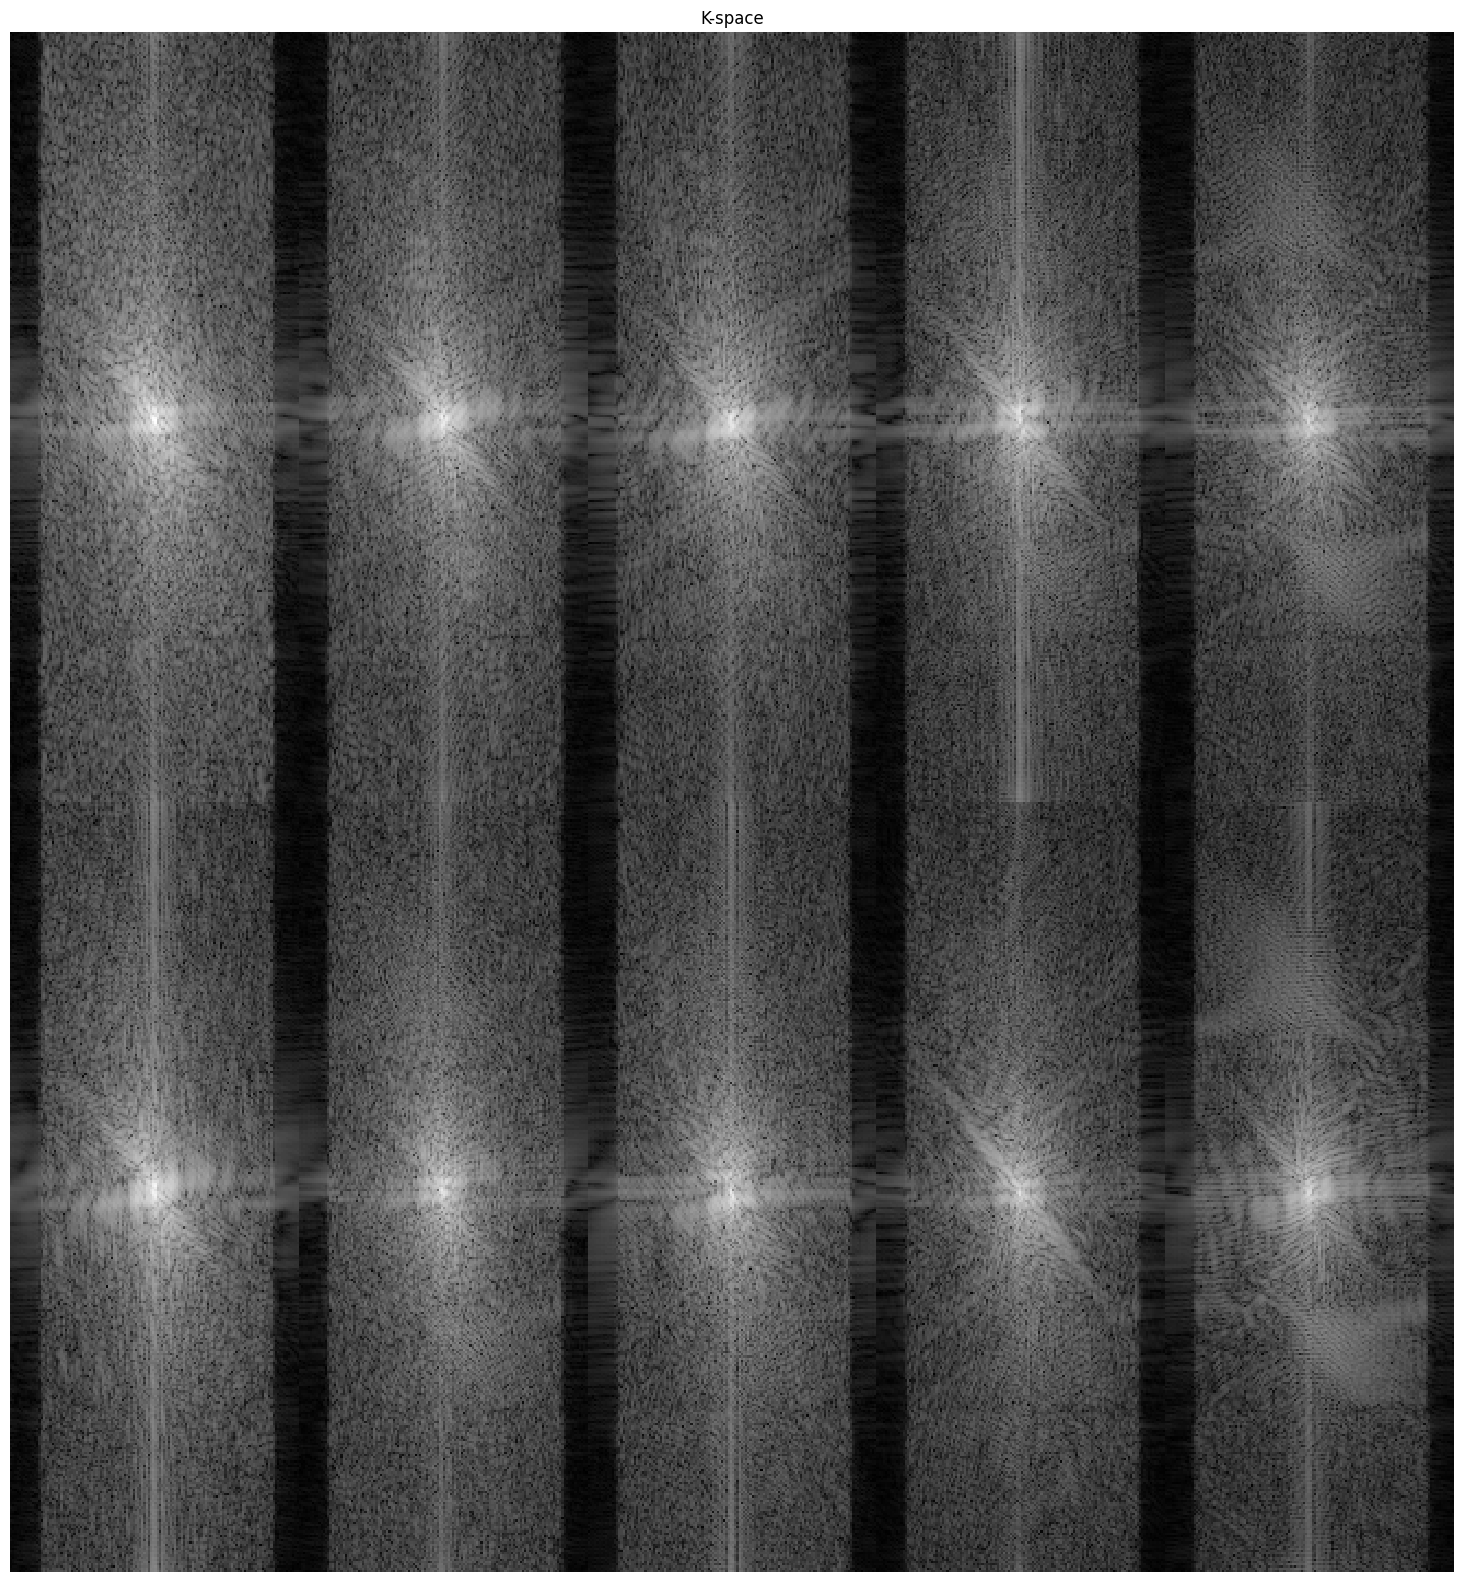

In [33]:
if datatype == 'brain':
    medutils.visualization.kshow(medutils.visualization.plot_array(kspace, M=2, N=8), title='K-space', figsize=(40,20))  # brain
elif datatype == 'heart':
    medutils.visualization.kshow(medutils.visualization.plot_array(kspace, M=2, N=5), title='K-space', figsize=(40,20))  # heart

## Transforming k-space to image space
Let us now start to transform the `kspace` to images. Therefore, we require the centered 2d inverse Fourier transform. Application of the `ifft2c` to the k-space results in individual coil images.

**Task 1: Write the function `ifft2c(kspace)`**

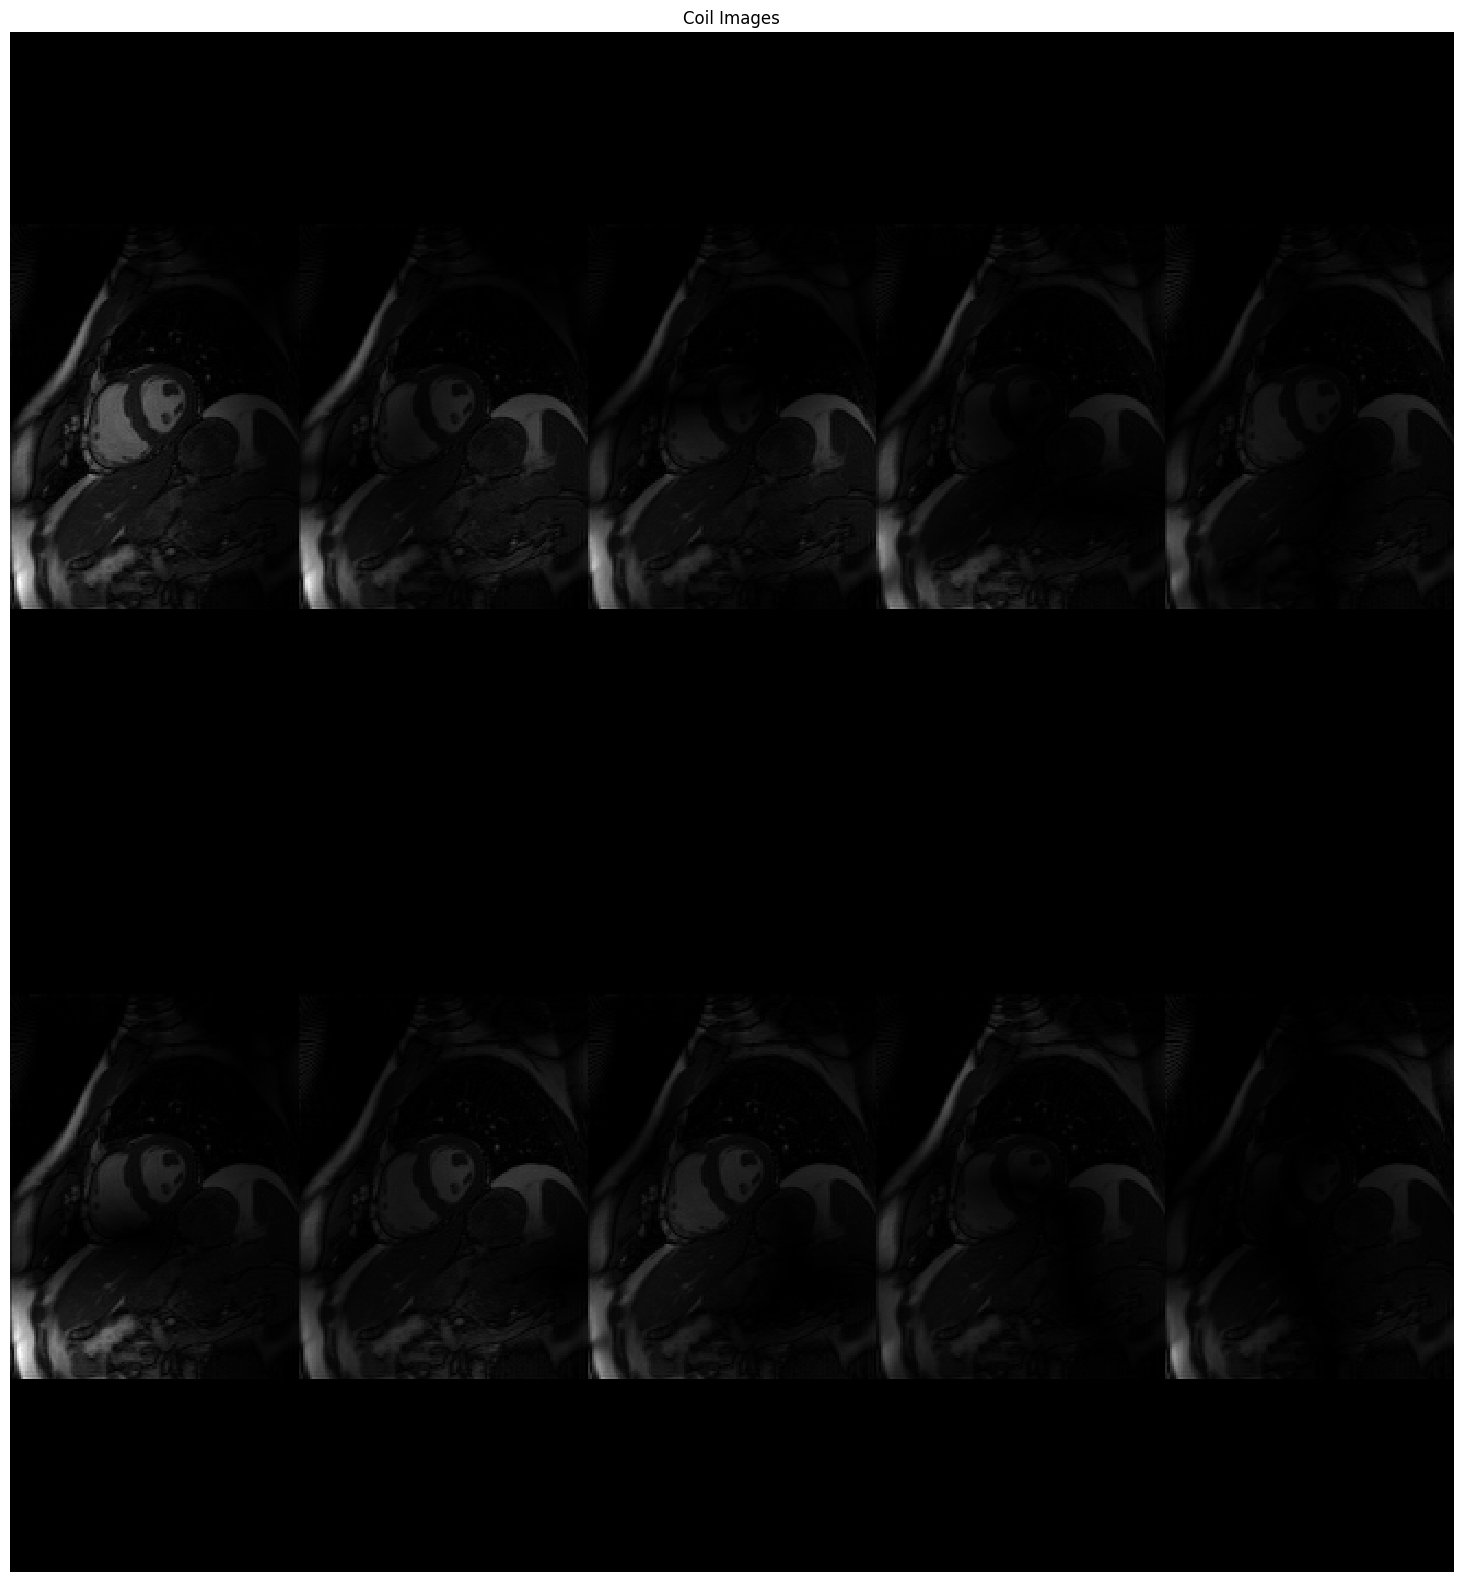

In [34]:
def ifft2c(kspace):
  # TODO implement the centered inverse FFT.
  return np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(kspace), norm='ortho'))

coil_img = ifft2c(kspace)
if datatype == 'brain':
    medutils.visualization.imshow(medutils.visualization.plot_array(coil_img, M=2, N=8), title='Coil Images', figsize=(40,20))
elif datatype == 'heart': 
    medutils.visualization.imshow(medutils.visualization.plot_array(coil_img, M=2, N=5), title='Coil Images', figsize=(40,20))

You might notice several things. First, you see that only a fraction of the image is bright. This is due to the effect that the coils are sensitive only in a certain spatial region. Second, you might notice that there are a lot of black areas all over the image, especially in column direction. This extended field of view in read-out direction, also termed frequency-encoding direction is actually for free, i.e. does not cost any additional acquisition time, and is acquired per default on MRI scanners. Assuming the base resolution is 320, the number of frequency encoding steps is (at least) doubled. This frequency oversampling results in an increased field-of-view in this direction. After the image is transformed to image domain, only the central part needs to be visualized. Thus, for display, we will from now on only consider the central part.

## Root-Sum-of-Squares Reconstruction

Now, we calculate the Root-Sum-of-Squares reconstruction $x_{rss}$
$$ x_{rss} = \sqrt{ \sum_{c=1}^{nCoils} \vert x_c \vert ^ 2 }, $$

where $x_c$ are the individual coil images. Note that using the root-sum-of-squares reconstruction, the phase information of the complex-valued data gets lost. 

We now visualize only the central part of the reconstructed image of size `[nFE//2, nPE]`. 

**Task 2: Implement the RSS reconstruction `rss(coil_img)`**

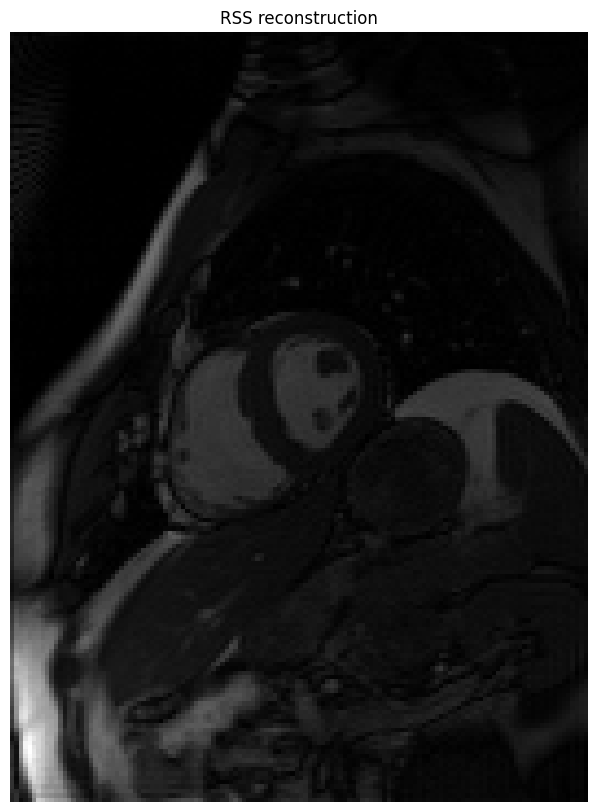

In [35]:
def rss(coil_img):
  # TODO implement the rss reconstruction
  return np.sqrt(np.sum(np.abs(coil_img)**2, 0))

x_rss = rss(coil_img)
medutils.visualization.imshow(medutils.visualization.center_crop(x_rss, (nFE//2, nPE)), figsize=(10,10), title='RSS reconstruction')

# Sensitivity Map Estimation

The coil sensitivity maps (`smaps`) are smooth maps that show us in which parts the individual coil elements are sensitive. We will need these information for our multi-coil MRI forward and adjoint operators. We use the [python implementation](https://github.com/mikgroup/espirit-python) for ESPIRiT [1,2] to estimate these coil sensitivity maps.

[1] Uecker et al. [ESPIRiT—an eigenvalue approach to autocalibrating parallel MRI: Where SENSE meets GRAPPA](https://onlinelibrary.wiley.com/doi/10.1002/mrm.24751). Magn Reson Med 71(3):990-1001, 2014.

[2] https://github.com/mikgroup/espirit-python

In [36]:
import espirit
kspace_espirit = np.transpose(kspace, (1, 2, 0))[:,:,np.newaxis]
smaps_espirit = espirit.espirit(kspace_espirit, 8, 24, 0.05, 0)

smaps = smaps_espirit[:,:,0,:,0]
smaps = np.transpose(smaps, (2, 0, 1))

Let us visualize the coil sensitivity maps for our k-space.

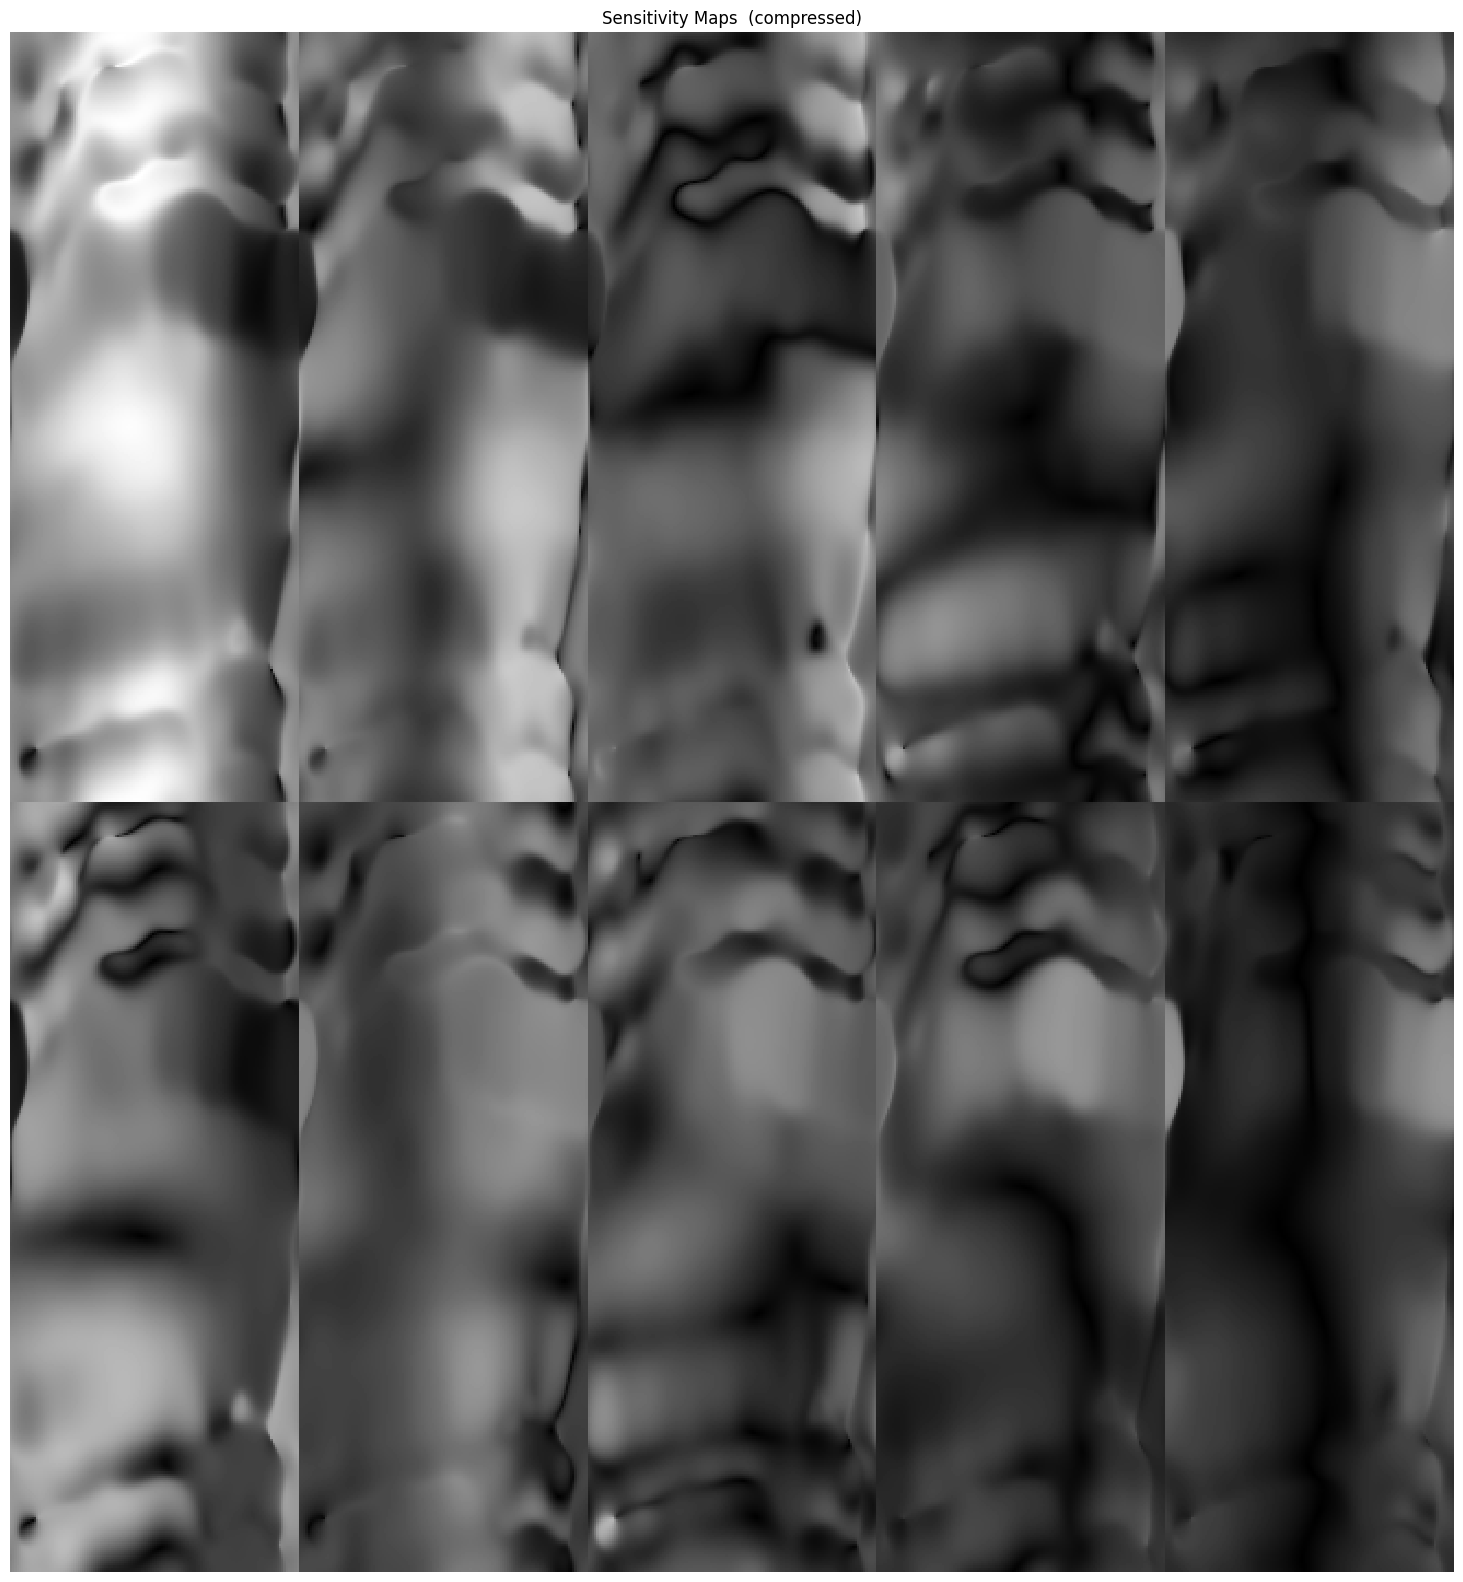

In [ ]:
medutils.visualization.imshow(medutils.visualization.plot_array(smaps), title='Sensitivity Maps  (compressed)', figsize=(40,20))

# Multi-Coil Operators and Sensitivity-Weighted coil combination

Now, we have all ingredients to combine the image which we merge into the forward and adjoint MRI multi-coil operators. The forward operator $A$ operator is defined as:

$$A= \Phi \mathcal{F} S $$

where $\Phi$ refers to the sampling mask/trajecory, $\mathcal{F}$ describes the Fourier transformation, and $S$ are the coil sensitivity maps. The adjoint operator $A^*$ is subsequently given as:

$$A^*= S^H \mathcal{F}^{-1} \Phi $$

**Task 3: Implement the multi-coil forward operator $A$ in `mriForwardOp(image, smaps, mask)` and adjoint operator $A^*$ in `mriAdjointOp(kspace, smaps, mask)`.**

*Hint: Start with the implementation of the adjoint operator and make use of the previously written function `ifft2c`. Then, define a function `fft2c` which is the 2D centered Fourier transform before you continue with the forward operator. We perform a centered FFT with `ortho` normalization in order to provide adjoint operators.* 

## Suggested Readings:

Pruessmann et al. [SENSE: Sensitivity encoding for fast MRI](https://onlinelibrary.wiley.com/doi/abs/10.1002/%28SICI%291522-2594%28199911%2942%3A5%3C952%3A%3AAID-MRM16%3E3.0.CO%3B2-S) Magnetic Resonance in Medicine, 43(5):952-962, 1999.


In [38]:
def mriAdjointOp(kspace, smaps, mask):
  # TODO implement
  return np.sum(ifft2c(kspace * mask)*np.conj(smaps), axis=0)

def fft2c(image):
  # TODO implement
  return np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(image), norm='ortho'))

def mriForwardOp(image, smaps, mask):
  # TODO implement
  return fft2c(smaps * image) * mask

Now, you should check if the adjoint operator is working as expected. The result should be a coil-combined image. Right now, there is no undersampling mask involved, i.e., it is set to all ones.

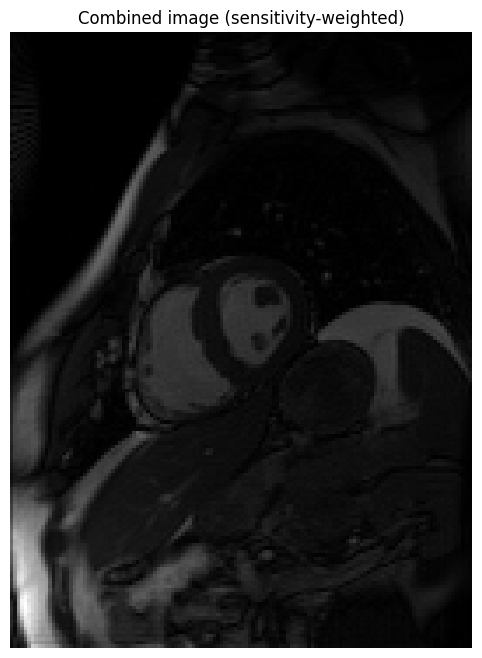

In [39]:
img_cc = mriAdjointOp(kspace, smaps, np.ones_like(kspace))
medutils.visualization.imshow(medutils.visualization.center_crop(img_cc, (nFE//2, nPE)), title='Combined image (sensitivity-weighted)', figsize=(8,8))

**Task 4: Adjointness check**

Now, also check if the operators are adjoint using the following equation:
$$ \langle Au, v\rangle = \langle u, A^Hv\rangle,$$
where $u$ and $v$ are complex random numbers. The variable $u$ should have the same size as the image $x$ and $v$ should have the same size as the k-space $y$. Note, that the sampling mask and sensitivity maps are kept constant. To create random numbers, use `np.random.randn`. Print the results for the left-hand side and right-hand side of the equation.<br/>

This check is particularly important when we later want to integrate the operators into our machine learning reconstruction. In there, the operators are called in the forward as well as in the backpropagation path (or at other locations depending on the ML reconstruction type), and can hence have a significant influence on the training to skew the results or lead to numerical instabilities.  

*Hint: To get the correct result, you might use the `conj` when computing the complex-valued dot product. Also, the forward and inverse Fourier transform have to be scaled the same way (`norm='ortho'`) to get correct results.*

In [40]:
# TODO implement the adjointness check
u = np.random.randn(*img_cc.shape) + 1j * np.random.randn(*img_cc.shape)
v = np.random.randn(*kspace.shape) + 1j * np.random.randn(*kspace.shape)


lhs = np.sum(np.conj(mriForwardOp(u, smaps, np.ones_like(kspace))) * v)
rhs = np.sum(np.conj(u) * mriAdjointOp(v, smaps, np.ones_like(kspace)))

print(f'{lhs} == {rhs}')

(-69.32735004554566+82.4966468191435j) == (-69.32735004554542+82.49664681914373j)


# Undersampling
Now we will get to the most exciting part of this exercise - undersampling the k-space! We will generate undersampling masks for acceleration $R\in\lbrace 2,4\rbrace$. 

**Task 5: Your task is to play around with different undersampling patterns. Generate a sampling pattern in the function `generate_mask(R, nPE, nFE, mode)` where `R` is the acceleration factor and `mode` is an integer corresponding to following patterns:**
1. Choose randomly an integer {0,1} with propability `p=[1-1/R, 1/R]`
2. Only set a dense block of `nRef=20` lines in the center of k-space.
3. Combine 1.+2.
4. Only set every `R`-th line
5. Combine 2.+4. 

To create the mask, simply generate a 1D line of size `nPE`. For each item, compute and print the effective acceleration `Reff`, which is determined by `nPE` divided by the number of sampled points. 

The code to get the full mask of size `[nFE, nPE]` is given below.

To continue the tasks on iterative reconstruction, please use `mode=3` and `R=4` as well as `mode=5` and `R=4`.

In [41]:
# TODO generate undersampling masks
def generate_mask(R, nPE, nFE, mode):
  nRef = 20
  if mode == 1:
    mask = np.random.choice([1, 0],(nPE),p=[1/R, 1-1/R])
  elif mode == 2:
    mask = np.zeros(nPE)
    mask[nPE//2-nRef//2:nPE//2+nRef//2] = 1
  elif mode == 3:  # CS
    mask = np.random.choice([1, 0],(nPE),p=[1/R, 1-1/R])
    mask[nPE//2-nRef//2:nPE//2+nRef//2] = 1
  elif mode == 4:
    mask = np.zeros(nPE)
    mask[::R] = 1
  elif mode == 5:  # PI
    mask = np.zeros(nPE)
    mask[::R] = 1
    mask[nPE//2-nRef//2:nPE//2+nRef//2] = 1
  else:
    raise ValueError(f'Mode {mode} not defined')

  Reff = nPE/np.sum(mask)
  print(f'Reff={Reff}')

  mask = mask.reshape(1, nPE).repeat(nFE, axis=0)

  return mask

Now, generate the mask and visualize it (we visualize only a fraction in frequency encoding direction).

Reff=2.869565217391304


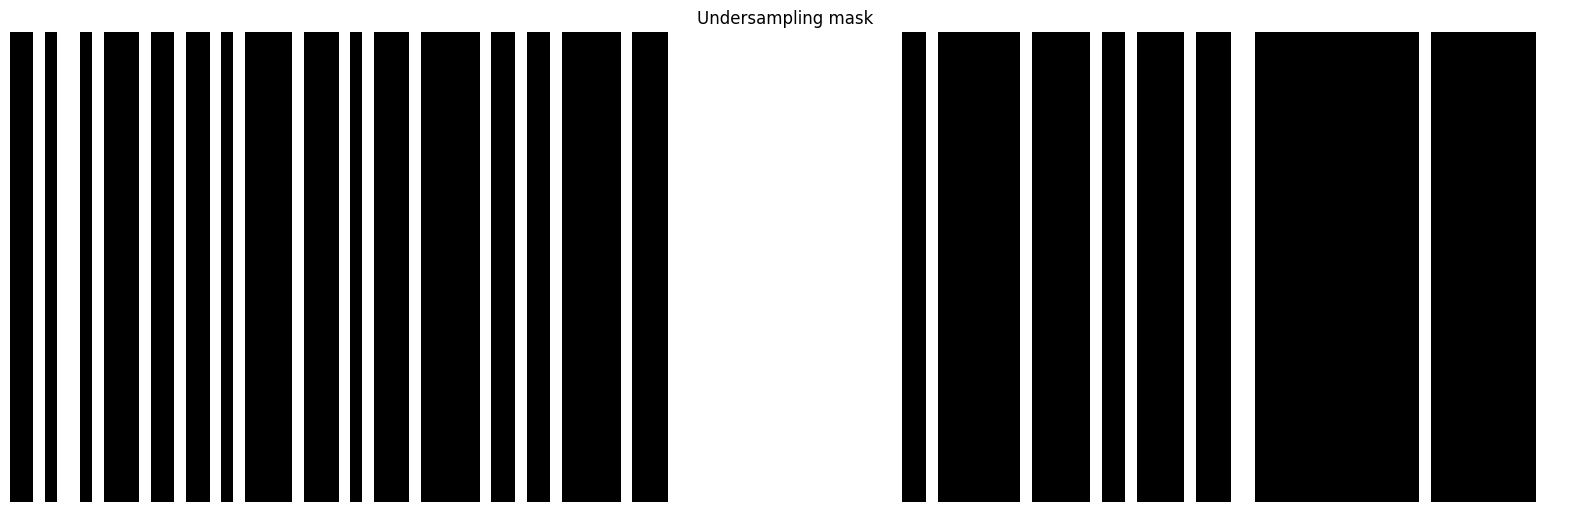

In [138]:
np.random.seed(1001)
mask = generate_mask(R=4, nPE=nPE, nFE=nFE, mode=3)

medutils.visualization.imshow(mask[:40,:], 'Undersampling mask', figsize=(20,20))

**Task 6: Zero-Filling solution**

Now you are ready to estimate the zero filling solution by applying the adjoint operator to the data, by using the estimated undersampling mask `mask`. Play around with above mask configurations. How do the images change?

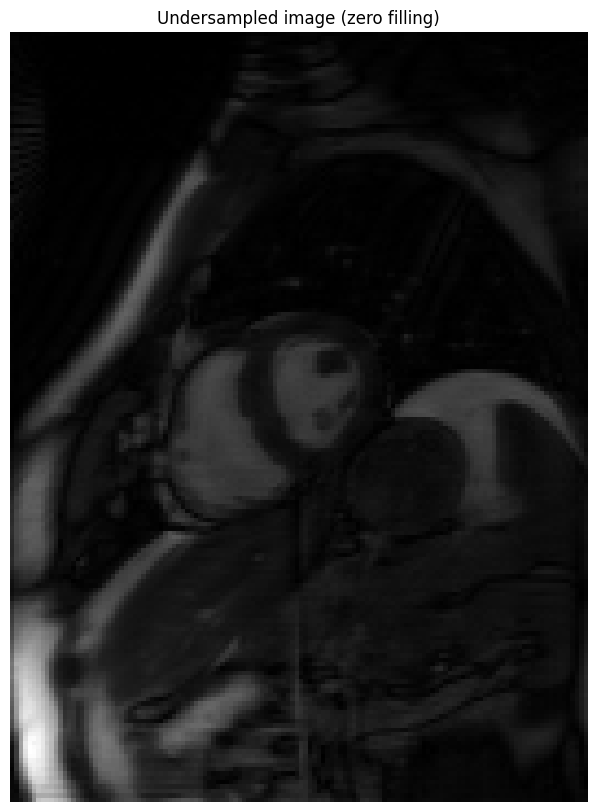

In [115]:
#TODO Apply the adjoint operator to the data and use the newly created undersampling mask.
img_cc_us = mriAdjointOp(kspace, smaps, mask)
img_cc_us = medutils.visualization.center_crop(img_cc_us, (nFE//2, nPE))
medutils.visualization.imshow(img_cc_us, 'Undersampled image (zero filling)', figsize=(10,10))

# Linear and Regularized Reconstruction
Now, we are ready to implement linear and regularized reconstruction. We additionally need the gradient operator, implementing forward / backward differences in `D` and `DT`, and the multi-coil MRI forward and adjoint operators, `A` and `AH`, respectively.

In [119]:
def nabla(x):
    dx = np.pad(x[:,1:], [[0, 0],[0, 1]], mode='edge')
    dy = np.pad(x[1:], [[0, 1],[0, 0]], mode='edge')
    return np.concatenate([dx[None,...] - x, dy[None,...] - x], 0)

def nablaT(x):
    assert x.shape[0] == 2
    dx = np.pad(x[0,:,:-1], [[0, 0],[1, 0]], mode='constant')
    dy = np.pad(x[1,:-1], [[1, 0],[0, 0]], mode='constant')
    return dx - x[0] + dy - x[1] 

D = lambda x: nabla(np.real(x)) + 1j * nabla(np.imag(x))
DT= lambda x: nablaT(np.real(x)) + 1j * nablaT(np.imag(x))

In [120]:
A = lambda x: mriForwardOp(x, smaps, mask)
AH = lambda x: mriAdjointOp(x, smaps, mask)

## Solving the linear reconstruction problem
Consider the following minimization problem:

$$ \min_x  E(x,y) = \min_x \frac{1}{2} \Vert Ax - y \Vert_2^2 .$$

While in image denoising we are still able to compute a closed-form solution for this problem, this is not feasible for the task of MRI reconstruction anymore. We instead use first-order optimization methods and solve this by Gradient Descent:
$$ x^{k+1} = x^{t} - \alpha \nabla_x E(x,y) $$
$$ x^{k+1} = x^{k} - \alpha A^H (Ax^k - y) $$

**Task 7: Implement Gradient Descent in `opt_linear` to solve the linear reconstruction problem and run the optimization for `max_iter=50` iterations and a step size of `alpha=1`**

In [121]:
def opt_linear(y, max_iter, alpha):
    x = np.zeros_like(AH(y))

    #TODO implement gradient descent to solve the linear reconstruction problem
    for _ in range(max_iter):
        x = x - alpha * AH(A(x) - y)
    return x

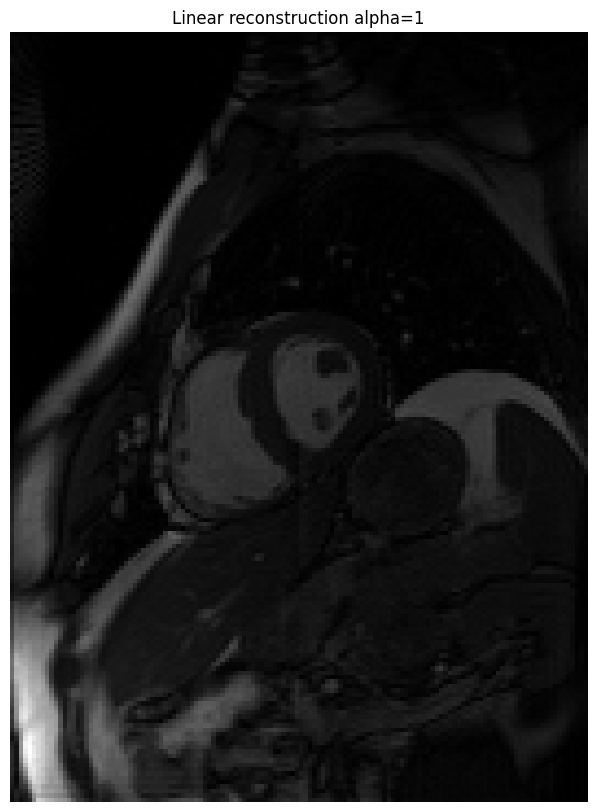

In [122]:
alpha=1
img_linear = opt_linear(kspace, max_iter=50, alpha=alpha)
img_linear = medutils.visualization.center_crop(img_linear, (nFE//2, nPE))
medutils.visualization.imshow(img_linear, f'Linear reconstruction alpha={alpha}', figsize=(10,10))

## L2-H1 Regularization

Now, we regularize the least-squares problem with a regularizer of form $\mathcal{R}(x)=\frac{1}{2} \Vert \nabla x \Vert_2^2$.
Consider now the following minimization problem

$$ \min_x  D(x,y) + \lambda R(x) = \min_x \frac{1}{2}\Vert Ax - y \Vert_2^2 + \frac{\lambda}{2}\Vert \nabla x \Vert_2^2.$$

We solve this by Gradient Descent:
$$ x^{k+1} = x^{k} - \alpha \left( \nabla_x D(x,y) + \nabla_x R(x) \right) $$
$$ x^{k+1} = x^{k} - \alpha \left( A^H (Ax^k - y) + \lambda \nabla^T \nabla x^k \right) $$

**Task 8: Implement gradient descent to solve the L2-H1 regularized problem and run the optimization for `max_iter=200` iterations, a step size of `alpha=1.0` and a regularization parameter of `lambd=0.01`.**

*Note that we do not have the best setting for the parameters here and the difference to the linear reconstruction might be only minimal. You can play around with the hyper-parameters. This example is to show you the properties of L2-H1 regularization and that it is actually hard to find a good set of hyper-parameters (step size, regularization parameters, iterations).*

In [123]:
def opt_reg_l2(y, max_iter, alpha, lambd):
    x = np.zeros_like(AH(y))
    # TODO implement gradient descent for L2-H1 regularization
    for _ in range(max_iter):
        x = x - alpha * AH(A(x) - y) - alpha * lambd * DT(D(x))
    return x

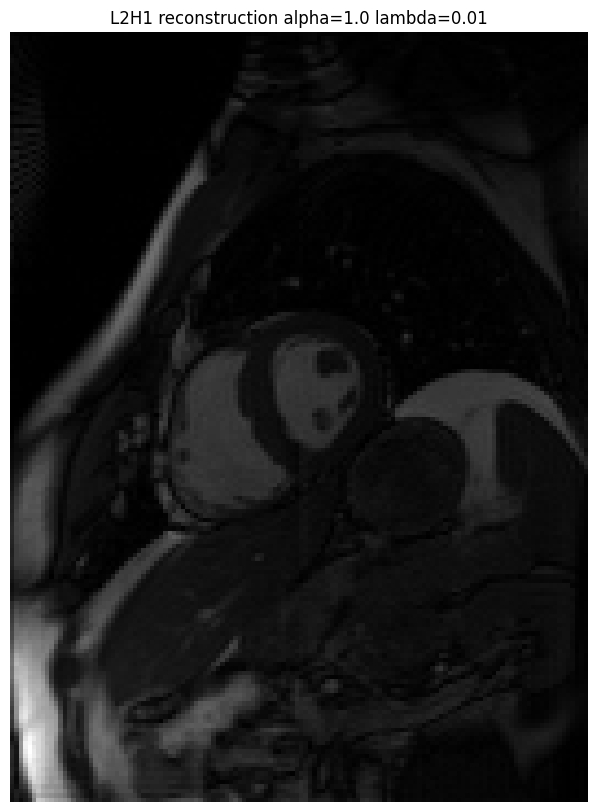

In [124]:
alpha = 1.0
lambd = 0.01
img_reg_l2 = opt_reg_l2(kspace, max_iter=200, alpha=alpha, lambd=lambd)
img_reg_l2 = medutils.visualization.center_crop(img_reg_l2, (nFE//2, nPE))
medutils.visualization.imshow(img_reg_l2, f'L2H1 reconstruction alpha={alpha} lambda={lambd}', figsize=(10,10))

## Sparse MRI: Wavelet Thresholding
Medical images per se are not sparse, however, they might have a sparse representation in some transform domain. One example here is the Wavelet transform, resulting in a multi-level feature representation. We provide the `plot_wavedec` function to find out how the sparse images look like at different scales and orientations.

We perform an optimization first wrt. data consistency term. This is followed by a Wavelet transform, and the *detailed* Wavelet coefficients are surpressed by using soft-thresholding, i.e.,

$$
\text{thresh}(x) = \frac{x}{\vert x \vert}\max(\vert x \vert - \alpha\lambda , 0)
$$

**Task 9: Implement the soft-thresholding in `soft_thresh(x, tau)`**

*Hint: Note, that the absolut value could get zero, and a small epsilon might be adorable to surpress this.*

### Suggested Readings

Lustig et al. [Compressed Sensing MRI](https://ieeexplore.ieee.org/document/4472246), IEEE Signal Processing Magazine 25(2):72-82, 2008.

Lustig et al. [Sparse MRI: The application of compressed sensing for rapid MR imaging](https://onlinelibrary.wiley.com/doi/full/10.1002/mrm.21391). Magnetic Resonance in Medicine 58(6):1182-1195, 2007.

In [125]:
def soft_thresh(x, tau):
    #TODO: implement soft-thresholding
    return x / np.maximum(np.abs(x), 1e-9) * np.maximum(np.abs(x) - tau, 0)

In [126]:
import pywt

def plot_wavedec(img, wavelet='db4', level=2):
    img = medutils.visualization.center_crop(img_cc, (nFE//2, nPE))
    coeffs = pywt.wavedecn(img, wavelet=wavelet, level=level)
    # normalize coeffs
    coeffs[0] /= np.max(np.abs(coeffs[0]))
    for level in range(1, len(coeffs)):
        for key in coeffs[level].keys():
            coeffs[level][key] /= np.max(np.abs(coeffs[level][key]))
    arr, coeff_slices = pywt.coeffs_to_array(coeffs)
    medutils.visualization.imshow(arr, figsize=(10,10))

def opt_reg_wavelet(y, max_iter, alpha, lambd, wavelet='db4', level=3):
    x = np.zeros_like(AH(y))
    wavelet_object = pywt.Wavelet(wavelet)
    threshold = alpha * lambd

    for _ in range(max_iter):
        x = x - alpha * (AH(A(x) - y))
        coeffs = pywt.wavedecn(x, wavelet_object, level=level)
        array, coeff_slices = pywt.coeffs_to_array(coeffs)
        denoised_array=soft_thresh(array, threshold)
        denoised_coeffs = pywt.array_to_coeffs(denoised_array, coeff_slices, output_format='wavedecn')
        denoised_coeffs[0] = coeffs[0]
        x = pywt.waverecn(denoised_coeffs, wavelet_object)
        
    return x

Next, we define a wavelet, the number of levels for decomposition and plot the decomposition.

/Users/thomas/miniconda3/envs/ismrm25/lib/python3.11/site-packages/pywt/_multilevel.py:43: UserWarning: Level value of 3 is too high: all coefficients will experience boundary effects.
  warnings.warn(


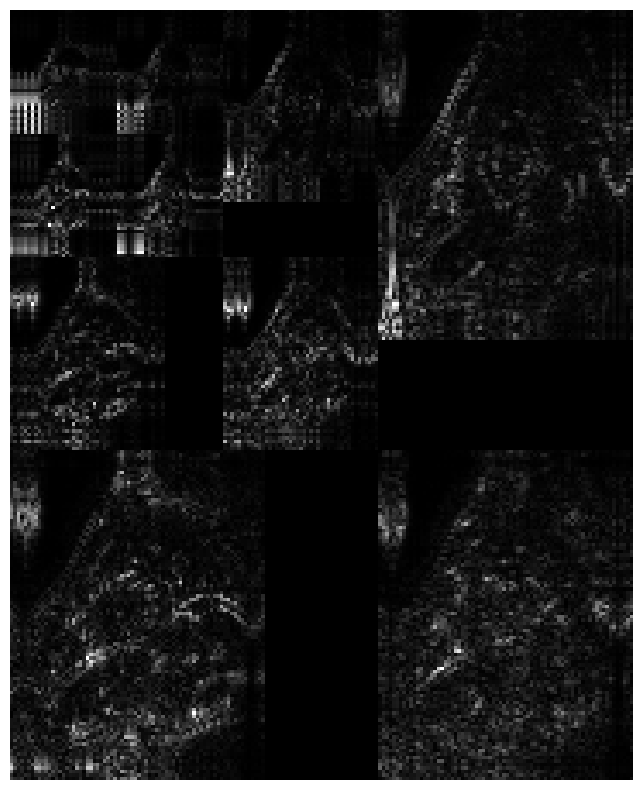

In [127]:
# Plot Wavelet Decomposition
wavelet='bior2.8'
level=3
plot_wavedec(img_cc, wavelet, level)

Finally, we run the optimization for `lambd=1e-6` and `alpha=1` and 200 iterations.

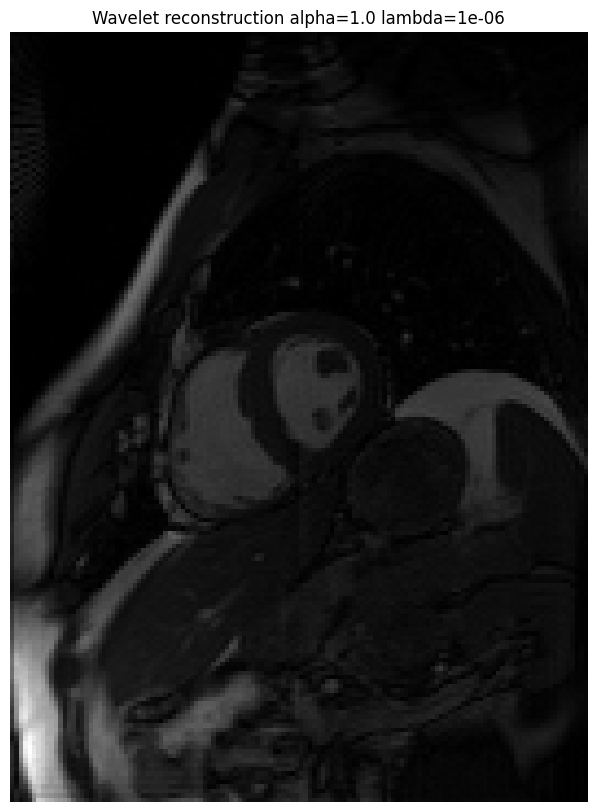

In [128]:
lambd=1e-6
alpha=1.0
img_reg_wavelet = opt_reg_wavelet(kspace, max_iter=200, alpha=alpha, lambd=lambd, wavelet=wavelet, level=level)
img_reg_wavelet = medutils.visualization.center_crop(img_reg_wavelet, (nFE//2, nPE))
medutils.visualization.imshow(img_reg_wavelet, f'Wavelet reconstruction alpha={alpha} lambda={lambd}', figsize=(10,10))

# Machine learning reconstruction
After we are able to run a conventional MR image reconstruction, we want to work on a learnable regularizer. For sake of simplicity and computational runtime, we will use the MNIST database (handwritten digits), for which we will create "fake" k-spaces. The same principles and code work however for any real MRI data, for example from public sources: [fastMRI](https://fastmri.med.nyu.edu/), [MRIData](http://mridata.org/).

## Learnable denoiser (real-valued)
We start of by learning a magnitude-based (real-valued) denoiser. We first define the data pipelines to feed the data into training, validation and test set. The MNIST database is used for showcasing. A white Gaussian noise is simulated retrospectively and added to the data. The task of the network is to denoise the images with real-valued operations.

### Database pipeline
First define the data pipelines (in the form of dataset classes) for training, validation and test set. Retrospective noise simulation is performed inside the dataset class. You may use the provided dataset links to MNIST from [Torch](https://pytorch.org/vision/main/generated/torchvision.datasets.MNIST.html) or [Tensorflow](https://www.tensorflow.org/datasets/catalog/mnist). We have prepared for you already the data pipeline `DataGeneratorMNIST()`. We will showcase the Torch and merlinth implementation. A similar example can be performed with Tensorflow and merlintf.

**Task 10: Implement the retrospective noise simulation in `_noisy()`**

In [104]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets

class DataGeneratorMNIST(Dataset):
    'Generates real-valued data for keras model'

    def __init__(self, noise_level=0.1, mode='train'):
        'Initialization'
        assert mode in ['train', 'val', 'test']

        self.noise_level = noise_level
        if not hasattr(self, 'dtype'):
            self.dtype = np.float32

        if mode in ['train', 'val']:
            self.img = datasets.MNIST(root='./data', train=True, download=True).data
        else:
            self.img = datasets.MNIST(root='./data', train=False, download=True).data

        # ATTENTION!
        # This code part is performing a random database splitting for training/validation, as all MNIST images
        # are independent of each other. In case of MRI, a patient leave-out approach needs to be performed!!!
        # predefined 80/20 split. MNIST has 60000 samples
        cv_split = {'train': 48000, 'val': 12000}
        if mode == 'train':
            self.img = self.img[0:cv_split['train']]
        elif mode == 'val':
            self.img = self.img[-cv_split['val']:]

        # prepare data
        self._prepare_data()

        # save the size of the images
        self.dim = self.img.shape[1:]

        # get amount of data samples in train/val/test
        self.n_samples = self.img.shape[0]

    def _prepare_data(self):
        'Data preparation'
        # convert uint8 to float32
        self.img = self.img.to(torch.float32) / 255.0

    def __len__(self):
        'Denotes the number of samples'
        return self.n_samples

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        sample = self.img[index]

        # Get target
        target = sample.unsqueeze(0)  # Add channel dimension

        # Generate noisy input
        noisy = self._noisy(sample).unsqueeze(0)   # Add channel dimension

        return noisy, target

    def _noisy(self, x):
        'Real-valued noise simulation'
        #TODO: implement the noise simulation
        # add Gaussian noise
        return x + torch.randn(*x.shape) * self.noise_level

Next, we define the actual data pipelines for training, validation and test. We will use the Torch [`DataLoader`](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#preparing-your-data-for-training-with-dataloaders) that builds the batches for our network input and calls our `DataGeneratorMNIST` dataset.

**Task 11: Write the `training_generator` (batch size 32, noise level 0.5), `validation_generator` (batch size 32, noise level 0.5), and `test_generator` (batch size 1, noise level 0.5)**

In [105]:
from torch.utils.data import DataLoader
# initialize some parameters
noise_level = 0.5  # simulated additive white Gaussian noise level

# Data Generators (Data pipeline) for real-valued data
# training set
#TODO: implement the data generator for training
training_generator = DataLoader(DataGeneratorMNIST(noise_level, mode='train'), batch_size=32, shuffle=True)

# validation set
#TODO: implement the data generator for validation
validation_generator = DataLoader(DataGeneratorMNIST(noise_level, mode='val'), batch_size=32, shuffle=False)

# test set
# ideally testing should be performed on real noisy cases and not simulated ones
#TODO: implement the data generator for testing
test_generator = DataLoader(DataGeneratorMNIST(noise_level, mode='test'), batch_size=32, shuffle=False)

print('Training batches to process:', len(training_generator))
print('Validation batches to process:', len(validation_generator))
print('Test samples to process:', len(test_generator))

Training batches to process: 1500
Validation batches to process: 375
Test samples to process: 313


### Model
Now let us define a simple denoiser architecture in the form of a convolutional neural network (CNN). 

**Task 12: Define a 3-layer CNN model with ReLU activation function. Define its corresponding inputs and outputs. Each layer shall have 8 filters, a kernel size of 3x3, no striding, and a ReLU activation function.**

In [106]:
# Generate model
import torch
import torch.nn.functional as F

# Define the input tensor (batch_size=1, channels=1, height=28, width=28)
input_tensor = torch.randn(1, 1, 28, 28)  # Example input

# Layer 1: Convolution + ReLU
conv1 = torch.nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=1, padding=1)
x = F.relu(conv1(input_tensor))

# Layer 2: Convolution + ReLU
conv2 = torch.nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3, stride=1, padding=1)
x = F.relu(conv2(x))

# Layer 3: Convolution + ReLU
conv3 = torch.nn.Conv2d(in_channels=8, out_channels=1, kernel_size=3, stride=1, padding=1)
output = F.relu(conv3(x))

# Print the output shape
print(output.shape)

torch.Size([1, 1, 28, 28])


or directly as `nn.Module` class, with layer initialization in `__init__` and a feed-forward path defined in `forward`.

In [130]:
# Generate Model
import torch.nn as nn

# Define the 3-layer CNN model in PyTorch
class ThreeLayerCNN(nn.Module):
    def __init__(self):
        super(ThreeLayerCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=1, padding=1)  # Conv layer 1
        self.relu1 = nn.ReLU()  # Activation for layer 1
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3, stride=1, padding=1)  # Conv layer 2
        self.relu2 = nn.ReLU()  # Activation for layer 2
        self.conv3 = nn.Conv2d(in_channels=8, out_channels=1, kernel_size=3, stride=1, padding=1)  # Conv layer 3
        self.relu3 = nn.ReLU()  # Activation for layer 3

    def forward(self, x):
        x = self.relu1(self.conv1(x))  # Apply Conv1 + ReLU
        x = self.relu2(self.conv2(x))  # Apply Conv2 + ReLU
        x = self.relu3(self.conv3(x))  # Apply Conv3 + ReLU
        return x

# Instantiate the model
model = ThreeLayerCNN()

# Print model summary
print(model)

ThreeLayerCNN(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (conv2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (conv3): Conv2d(8, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
)


We can also extend this 3-layer CNN to a 3-layer ResNet (residual network), in which a residual connection spans from input to the output. This is one way to avoid gradient vanishing for deeper networks.

**Task 13: Define the 3-layer ResNet (same layer parameters as before).**

In [131]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Define the 3-layer Residual CNN model in PyTorch
class Residual3LayerCNN(nn.Module):
    def __init__(self):
        super(Residual3LayerCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=1, padding=1)  # Conv layer 1
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3, stride=1, padding=1)  # Conv layer 2
        self.conv3 = nn.Conv2d(in_channels=8, out_channels=1, kernel_size=3, stride=1, padding=1)  # Conv layer 3

    def forward(self, x):
        residual = x  # Save the input for the residual connection
        x = F.relu(self.conv1(x))  # Apply Conv1 + ReLU
        x = F.relu(self.conv2(x))  # Apply Conv2 + ReLU
        x = F.relu(self.conv3(x))  # Apply Conv3 + ReLU
        x = x + residual  # Add the residual connection
        return x

# Instantiate the model
model = Residual3LayerCNN()

# Print model summary
print(model)

Residual3LayerCNN(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(8, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


In order to train the model we need to prepare the optimizer, loss function and validation metrics.

**Task 14: Define an Adam optimizer (learning rate 0.001), MSE loss function, and MSE and MAE for validation metrics.**

In [132]:
import torch.optim as optim

# Define the loss function
criterion = nn.MSELoss()  # Mean Squared Error loss

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer with learning rate 0.001

# Metrics (for evaluation during training/validation)
def mse_metric(output, target):
    return torch.mean((output - target) ** 2).item()

def mae_metric(output, target):
    return torch.mean(torch.abs(output - target)).item()

### Training

In order to train the model, we first need to build the training and validation [loop](https://pytorch.org/tutorials/beginner/introyt/trainingyt.html#the-training-loop) as a function `train_model`. 

**Task 15: Build the training and validation loop for all epochs. Train the configured 3-layer ResNet model over 3 epochs. Monitor training progress with the validation set.**

In [ ]:
from tqdm import tqdm

# Define the training loop
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs, mse_metric=mse_metric, mae_metric=mae_metric):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    for epoch in range(epochs):
        model.train()  # Set the model to training mode
        train_loss = 0.0

        # Training loop
        print(f"Epoch {epoch + 1}/{epochs}")
        with tqdm(total=len(train_loader), desc="Training", unit="batch") as pbar:
            for inputs, targets in train_loader:
                inputs, targets = inputs.to(device), targets.to(device)  # Move data to device (e.g., GPU)
                optimizer.zero_grad()  # Clear gradients
                outputs = model(inputs)  # Forward path
                loss = criterion(outputs, targets)  # Compute loss
                loss.backward()  # Backward path
                optimizer.step()  # Update weights
                train_loss += loss.item()
                pbar.update(1)  # Update progress bar

        # Validation loop
        model.eval()  # Set the model to evaluation mode
        val_loss = 0.0
        val_mse = 0.0
        val_mae = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()
                val_mse += mse_metric(outputs, targets)
                val_mae += mae_metric(outputs, targets)

        # Print epoch summary
        print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss / len(train_loader):.4f}, "
              f"Validation Loss: {val_loss / len(val_loader):.4f}, "
              f"Validation MSE: {val_mse / len(val_loader):.4f}, "
              f"Validation MAE: {val_mae / len(val_loader):.4f}")

In [136]:
# Example usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)  # Move model to device
train_model(model, training_generator, validation_generator, criterion, optimizer, epochs=3)

Epoch 1/3


Training: 100%|██████████| 1500/1500 [00:16<00:00, 91.24batch/s]


Epoch 1/3, Train Loss: 0.1316, Validation Loss: 0.1313, Validation MSE: 0.1313, Validation MAE: 0.2247
Epoch 2/3


Training: 100%|██████████| 1500/1500 [00:16<00:00, 90.31batch/s]


Epoch 2/3, Train Loss: 0.1314, Validation Loss: 0.1315, Validation MSE: 0.1315, Validation MAE: 0.2234
Epoch 3/3


Training: 100%|██████████| 1500/1500 [00:15<00:00, 94.00batch/s]


Epoch 3/3, Train Loss: 0.1313, Validation Loss: 0.1314, Validation MSE: 0.1314, Validation MAE: 0.2244


### Test
To display the performance metrics on the test set, we need to build a test loop (similar to the training loop), but without gradient backpropagation (`torch.no_grad()`). Afterwards we can test the trained model to predict a denoised output. 

**Task 16: Evaluate the model over the complete test set and run a model prediction for a single case.**

In [ ]:
# Evaluate the trained model
def evaluate_model(model, test_loader, criterion, mse_metric=mse_metric, mae_metric=mae_metric):
    model.eval()  # Set the model to evaluation mode
    test_loss = 0.0
    test_mse = 0.0
    test_mae = 0.0

    with torch.no_grad():  # Disable gradient computation
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)  # Move data to device (e.g., GPU)
            outputs = model(inputs)  # Forward path
            loss = criterion(outputs, targets)  # Compute loss
            test_loss += loss.item()
            test_mse += mse_metric(outputs, targets)
            test_mae += mae_metric(outputs, targets)

    # Compute average metrics
    avg_loss = test_loss / len(test_loader)
    avg_mse = test_mse / len(test_loader)
    avg_mae = test_mae / len(test_loader)

    print(f"Test Loss: {avg_loss:.4f}, Test MSE: {avg_mse:.4f}, Test MAE: {avg_mae:.4f}")

In [ ]:
# Example usage
evaluate_model(model, test_generator, criterion)

Test Loss: 0.1315, Test MSE: 0.1315, Test MAE: 0.2228


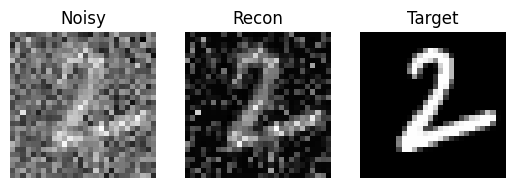

In [ ]:
# Predict with trained model
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Disable gradient computation
    inputs, targets = next(iter(test_generator))  # Get a batch from the test generator
    inputs, targets = inputs.to(device), targets.to(device)  # Move data to the appropriate device
    predicted_output = model(inputs)  # Forward path

# Display the predicted output
import matplotlib.pyplot as plt

icase = 0  # Display the first example
plt.figure()
plt.subplot(2, 3, 1)
plt.imshow(inputs[icase, 0].cpu().numpy(), cmap='gray')  # Noisy input
plt.title('Noisy')
plt.axis('off')

plt.subplot(2, 3, 2)
plt.imshow(predicted_output[icase, 0].cpu().numpy(), cmap='gray')  # Reconstructed output
plt.title('Recon')
plt.axis('off')

plt.subplot(2, 3, 3)
plt.imshow(targets[icase, 0].cpu().numpy(), cmap='gray')  # Ground truth
plt.title('Target')
plt.axis('off')

plt.show()

## Learnable denoiser (complex-valued data with 2-channel real-valued processing)
In many applications, denoising on the magnitude (real-valued) image can be sufficient. However, in order to proceed to an integration with data consistency, we need to consider the complex-valued nature of the MR data. The complex-valued data can be handled in the network either as real-valued operations (2-channel real-valued) or as complex-valued operations. We will examine the difference between them.
Let us start with the 2-channel real-valued network. We first define the data pipelines to feed the data into training, validation and test set. The MNIST database is used for showcasing. Since MNIST are real-valued images, a phase is simulated and added to the images to generate a complex-valued input. A white Gaussian noise is simulated retrospectively and added to the data. The task of the network is to denoise the images with real-valued operations, i.e. complex data is stored in channel dimension as 2 real-valued tensors.

### Database pipeline
First define the data pipelines (in the form of generator functions) for training, validation and test set. Retrospective noise simulation is performed inside the generator functions. We have prepared for you already the data pipeline `TwoChannelDataGeneratorMNIST(DataGeneratorMNIST)`.

**Task 17: Implement the retrospective complex-valued noise simulation in `_noisy()`**

**Task 18: Implement the complex-valued to 2-channel real-valued conversion into the data pipeline.**

In [ ]:
class TwoChannelDataGeneratorMNIST(DataGeneratorMNIST):
    """Generates complex-valued data for PyTorch model"""

    def __init__(self, noise_level=0.1, mode='train'):
        """Initialization"""
        super().__init__(noise_level=noise_level, mode=mode)
        self.dtype = torch.float32

    def _prepare_data(self):
        'Data preparation'
        # Convert uint8 to float32 and normalize
        super()._prepare_data()
        # Simulate some phase information
        self.img = self.img + 1j * self.img.flip(0)
        self.img = self._normalize(self.img)

    def _complex2real(self, z, channel_last=False):
        'Convert complex-valued data to real-valued data'
        stack_dim = -1 if channel_last else 0
        real = torch.real(z).to(self.dtype)
        imag = torch.imag(z).to(self.dtype)
        return torch.cat([real.unsqueeze(stack_dim), imag.unsqueeze(stack_dim)], dim=stack_dim)

    def _normalize(self, x, min=0, max=1):
        'Normalization'
        if torch.is_complex(x):
            eps = 1e-9
            xabs = torch.abs(x)
            normed_magn = (xabs - xabs.min()) / (xabs.max() - xabs.min()) * (max - min) + min
            normed_magn = torch.clamp(normed_magn, min=eps)
            phase = torch.angle(x)
            return normed_magn * torch.exp(1j * phase)
        else:
            return (x - x.min()) / (x.max() - x.min()) * (max - min) + min

    def __getitem__(self, index):
        'Generate one batch of data'
        sample = self.img[index]

        # Get target
        target = self._complex2real(sample)  # complex to real

        # Generate noisy input
        noisy = self._complex2real(self._noisy(sample))  # complex to real

        return noisy, target

    def _noisy(self, x):
        'Complex-valued noise simulation'
        # Add complex Gaussian noise
        noise = self.noise_level / 2 * (torch.randn_like(x, dtype=self.dtype) + 1j * torch.randn_like(x, dtype=self.dtype))
        return x + noise

Next, we define the actual data pipelines for training, validation and test. 

**Task 19: Write the `training_generator`, `validation_generator`, and `test_generator` similar to the real-valued case.**

In [ ]:
from torch.utils.data import DataLoader
# initialize some parameters
noise_level = 0.5  # simulated additive white Gaussian noise level

# Data Generators (Data pipeline) for real-valued data
# training set
#TODO: implement the data generator for training
training_generator = DataLoader(TwoChannelDataGeneratorMNIST(noise_level, mode='train'), batch_size=32, shuffle=True)

# validation set
#TODO: implement the data generator for validation
validation_generator = DataLoader(TwoChannelDataGeneratorMNIST(noise_level, mode='val'), batch_size=32, shuffle=False)

# test set
# ideally testing should be performed on real noisy cases and not simulated ones
#TODO: implement the data generator for testing
test_generator = DataLoader(TwoChannelDataGeneratorMNIST(noise_level, mode='test'), batch_size=32, shuffle=False)

print('Training batches to process:', len(training_generator))
print('Validation batches to process:', len(validation_generator))
print('Test samples to process:', len(test_generator))

Training batches to process: 1500
Validation batches to process: 375
Test samples to process: 313


### Model
Now let us define a simple denoiser architecture in the form of a convolutional neural network (CNN). 

**Task 20: Define a 3-layer CNN model with its corresponding inputs and outputs - similar to the real-valued case.** (Hint: All operations are still real-valued.)

In [ ]:
# Generate Model
import torch.nn as nn

# Define the 3-layer CNN model in PyTorch
class ThreeLayerCNN2ch(nn.Module):
    def __init__(self):
        super(ThreeLayerCNN2ch, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=2, out_channels=8, kernel_size=3, stride=1, padding=1)  # Conv layer 1
        self.relu1 = nn.ReLU()  # Activation for layer 1
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3, stride=1, padding=1)  # Conv layer 2
        self.relu2 = nn.ReLU()  # Activation for layer 2
        self.conv3 = nn.Conv2d(in_channels=8, out_channels=1, kernel_size=3, stride=1, padding=1)  # Conv layer 3
        self.relu3 = nn.ReLU()  # Activation for layer 3

    def forward(self, x):
        x = self.relu1(self.conv1(x))  # Apply Conv1 + ReLU
        x = self.relu2(self.conv2(x))  # Apply Conv2 + ReLU
        x = self.relu3(self.conv3(x))  # Apply Conv3 + ReLU
        return x

# Instantiate the model
model = ThreeLayerCNN2ch()

# Print model summary
print(model)

ThreeLayerCNN2ch(
  (conv1): Conv2d(2, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (conv2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (conv3): Conv2d(8, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
)


Let us extend the architecture to a 3-layer ResNet (residual network).

**Task 21: Define the 3-layer ResNet (similar to real-valued case).**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Define the 3-layer Residual CNN model in PyTorch
class Residual3LayerCNN2ch(nn.Module):
    def __init__(self):
        super(Residual3LayerCNN2ch, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=2, out_channels=8, kernel_size=3, stride=1, padding=1)  # Conv layer 1
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3, stride=1, padding=1)  # Conv layer 2
        self.conv3 = nn.Conv2d(in_channels=8, out_channels=1, kernel_size=3, stride=1, padding=1)  # Conv layer 3

    def forward(self, x):
        residual = x  # Save the input for the residual connection
        x = F.relu(self.conv1(x))  # Apply Conv1 + ReLU
        x = F.relu(self.conv2(x))  # Apply Conv2 + ReLU
        x = F.relu(self.conv3(x))  # Apply Conv3 + ReLU
        x = x + residual  # Add the residual connection
        return x

# Instantiate the model
model = Residual3LayerCNN2ch()

# Print model summary
print(model)

Residual3LayerCNN2ch(
  (conv1): Conv2d(2, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(8, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


### Training
For training the 2-channel real-valued model, we can reuse the previous training loop, loss function and the optimizer definition.

**Task 22: Train the 3-layer ResNet model with an Adam optimizer (learning rate 0.001) for 3 epochs using an MSE loss function, and apply MSE and MAE as validation metrics.**

In [ ]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001) 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)  # Move model to device
train_model(model, training_generator, validation_generator, criterion, optimizer, epochs=3)

Epoch 1/3


Training: 100%|██████████| 1500/1500 [00:19<00:00, 78.34batch/s]


Epoch 1/3, Train Loss: 0.0479, Validation Loss: 0.0478, Validation MSE: 0.0478, Validation MAE: 0.1721
Epoch 2/3


Training: 100%|██████████| 1500/1500 [00:18<00:00, 79.63batch/s]


Epoch 2/3, Train Loss: 0.0479, Validation Loss: 0.0479, Validation MSE: 0.0479, Validation MAE: 0.1722
Epoch 3/3


Training: 100%|██████████| 1500/1500 [00:20<00:00, 74.91batch/s]


Epoch 3/3, Train Loss: 0.0479, Validation Loss: 0.0479, Validation MSE: 0.0479, Validation MAE: 0.1722


### Test

**Task 23: Test the trained model to predict a denoised output and to display performance (metrics) on the test set.**

In [ ]:
# evaluate trained model
evaluate_model(model, test_generator, criterion)

Test Loss: 0.0478, Test MSE: 0.0478, Test MAE: 0.1720


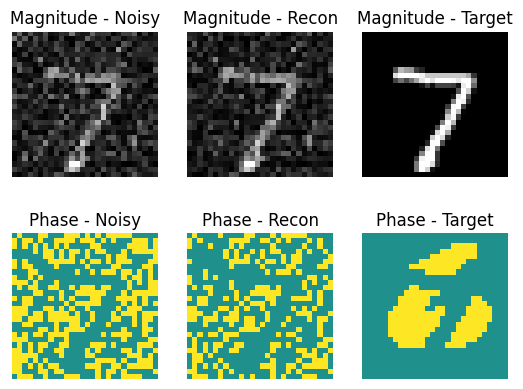

In [ ]:
# Predict with trained model
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Disable gradient computation
    inputs, outputs = next(iter(test_generator))  # Get a batch from the test generator
    inputs, outputs = inputs.to(device), outputs.to(device)  # Move data to the appropriate device
    predicted_output = model(inputs)  # Forward path

# Display the predicted output
import matplotlib.pyplot as plt
import numpy as np

icase = 0  # Display the first example
plt.figure()

# Magnitude - Noisy
plt.subplot(2, 3, 1)
plt.imshow(np.abs(inputs[icase, 0].cpu().numpy()), cmap='gray')
plt.title('Magnitude - Noisy')
plt.axis('off')

# Magnitude - Recon
plt.subplot(2, 3, 2)
plt.imshow(np.abs(predicted_output[icase, 0].cpu().numpy()), cmap='gray')
plt.title('Magnitude - Recon')
plt.axis('off')

# Magnitude - Target
plt.subplot(2, 3, 3)
plt.imshow(np.abs(outputs[icase, 0].cpu().numpy()), cmap='gray')
plt.title('Magnitude - Target')
plt.axis('off')

# Phase - Noisy
plt.subplot(2, 3, 4)
plt.imshow(np.angle(inputs[icase, 0].cpu().numpy()), vmin=-np.pi, vmax=np.pi)
plt.title('Phase - Noisy')
plt.axis('off')

# Phase - Recon
plt.subplot(2, 3, 5)
plt.imshow(np.angle(predicted_output[icase, 0].cpu().numpy()), vmin=-np.pi, vmax=np.pi)
plt.title('Phase - Recon')
plt.axis('off')

# Phase - Target
plt.subplot(2, 3, 6)
plt.imshow(np.angle(outputs[icase, 0].cpu().numpy()), vmin=-np.pi, vmax=np.pi)
plt.title('Phase - Target')
plt.axis('off')

plt.show()

## Learnable denoiser (complex-valued data with complex-valued processing)
Let us proceed now to a full complex-valued processing. We first define the data pipelines to feed the data into training, validation and test set. The MNIST database is used for showcasing. Since MNIST are real-valued images, a phase is simulated and added to the images to generate a complex-valued input. A white Gaussian noise is simulated retrospectively and added to the data. The task of the network is to denoise the images with complex-valued operations.

### Database pipeline
First define the data pipelines (in the form of generator functions) for training, validation and test set. Retrospective noise simulation is performed inside the generator functions. You can reuse your previous `TwoChannelDataGeneratorMNIST(DataGeneratorMNIST)` and only need to change a single line.

**Task 24: Implement the `ComplexDataGeneratorMNIST(TwoChannelDataGeneratorMNIST)`, and provide the respective data loader pipelines for training, validation and test.**

In [ ]:
class ComplexDataGeneratorMNIST(TwoChannelDataGeneratorMNIST):
    """Generates complex-valued data for PyTorch model"""

    def __init__(self, noise_level=0.1, mode='train'):
        """Initialization"""
        super().__init__(noise_level=noise_level, mode=mode)
        self.dtype = torch.complex64

    def __getitem__(self, index):
        """Generate one batch of data"""
        sample = self.img[index]

        # Get target
        target = sample.unsqueeze(0)  # Add channel dimension

        # Generate noisy input
        noisy = self._noisy(sample).unsqueeze(0)  # Add channel dimension

        return noisy, target

In [ ]:
from torch.utils.data import DataLoader
# initialize some parameters
noise_level = 0.5  # simulated additive white Gaussian noise level

# Data Generators (Data pipeline) for complex-valued data
# training set
#TODO: implement the data generator for training
training_generator = DataLoader(ComplexDataGeneratorMNIST(noise_level, mode='train'), batch_size=32, shuffle=True)

# validation set
#TODO: implement the data generator for validation
validation_generator = DataLoader(ComplexDataGeneratorMNIST(noise_level, mode='val'), batch_size=32, shuffle=False)

# test set
# ideally testing should be performed on real noisy cases and not simulated ones
#TODO: implement the data generator for testing
test_generator = DataLoader(ComplexDataGeneratorMNIST(noise_level, mode='test'), batch_size=32, shuffle=False)

print('Training batches to process:', len(training_generator))
print('Validation batches to process:', len(validation_generator))
print('Test samples to process:', len(test_generator))

Training batches to process: 1500
Validation batches to process: 375
Test samples to process: 313


### Model
Now let us define a convolutional neural network (CNN) denoiser that uses complex-valued operations and a cReLU activation function. We will use the [MERLIN](https://github.com/midas-tum) package to provide the complex-valued operations.

**Task 25: Define a 3-layer complex-valued CNN model with its corresponding inputs and outputs. Each layer shall have 8 filters, a kernel size of 3x3, no striding, and a cReLU activation function.**

In [ ]:
import merlinth
import torch.nn as nn
from merlinth.layers.complex_act import cReLU

# Define the 3-layer complex-valued CNN model in PyTorch
class ThreeLayerCNNc(nn.Module):
    def __init__(self):
        super(ThreeLayerCNNc, self).__init__()
        self.conv1 = merlinth.layers.ComplexConv2d(in_channels=1, out_channels=8, kernel_size=3, stride=1, padding=1)  # Conv layer 1
        self.relu1 = cReLU()  # Activation for layer 1
        self.conv2 = merlinth.layers.ComplexConv2d(in_channels=8, out_channels=8, kernel_size=3, stride=1, padding=1)  # Conv layer 2
        self.relu2 = cReLU()  # Activation for layer 2
        self.conv3 = merlinth.layers.ComplexConv2d(in_channels=8, out_channels=1, kernel_size=3, stride=1, padding=1)  # Conv layer 3
        self.relu3 = cReLU()  # Activation for layer 3

    def forward(self, x):
        x = self.relu1(self.conv1(x))  # Apply Conv1 + ReLU
        x = self.relu2(self.conv2(x))  # Apply Conv2 + ReLU
        x = self.relu3(self.conv3(x))  # Apply Conv3 + ReLU
        return x

# Instantiate the model
model = ThreeLayerCNNc()

# Print model summary
print(model)

ThreeLayerCNNc(
  (conv1): ComplexConv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): cReLU()
  (conv2): ComplexConv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): cReLU()
  (conv3): ComplexConv2d(8, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): cReLU()
)


**Task 26: Extend the architecture to a 3-layer complex-valued ResNet (residual network).**

In [ ]:
# Define the 3-layer complex-valued ResNet model in PyTorch
class Residual3LayerCNNc(nn.Module):
    def __init__(self):
        super(Residual3LayerCNNc, self).__init__()
        self.conv1 = merlinth.layers.ComplexConv2d(in_channels=1, out_channels=8, kernel_size=3, stride=1, padding=1)  # Conv layer 1
        self.relu1 = cReLU()  # Activation for layer 1
        self.conv2 = merlinth.layers.ComplexConv2d(in_channels=8, out_channels=8, kernel_size=3, stride=1, padding=1)  # Conv layer 2
        self.relu2 = cReLU()  # Activation for layer 2
        self.conv3 = merlinth.layers.ComplexConv2d(in_channels=8, out_channels=1, kernel_size=3, stride=1, padding=1)  # Conv layer 3
        self.relu3 = cReLU()  # Activation for layer 3

    def forward(self, x):
        residual = x  # Save the input for the residual connection
        x = self.relu1(self.conv1(x))  # Apply Conv1 + ReLU
        x = self.relu2(self.conv2(x))  # Apply Conv2 + ReLU
        x = self.relu3(self.conv3(x))  # Apply Conv3 + ReLU
        x = x + residual  # Add the residual connection
        return x

# Instantiate the model
model = Residual3LayerCNNc()

# Print model summary
print(model)

Residual3LayerCNNc(
  (conv1): ComplexConv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): cReLU()
  (conv2): ComplexConv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): cReLU()
  (conv3): ComplexConv2d(8, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): cReLU()
)


### Training
Before we can train the model, we need to make sure to use a complex-valued MSE and MAE. You can either define it yourself or use the ones provided by [merlinth](https://github.com/midas-tum/merlin/blob/master/pytorch/merlinth/losses/pairwise_loss.py).

**Task 27: Assign an Adam optimizer (learning rate 0.001) with complex-valued MSE loss function. Use the MSE and MAE for validation metrics. Train for 3 epochs.**

In [ ]:
from merlinth.losses import mse, mae

criterion = mse
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer with learning rate 0.001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)  # Move model to device
train_model(model, training_generator, validation_generator, criterion, optimizer, epochs=3, mse_metric=mse, mae_metric=mae)

Epoch 1/3


Training: 100%|██████████| 1500/1500 [01:12<00:00, 20.63batch/s]


Epoch 1/3, Train Loss: 52.4656, Validation Loss: 52.1477, Validation MSE: 52.1477, Validation MAE: 153.6461
Epoch 2/3


Training: 100%|██████████| 1500/1500 [01:12<00:00, 20.60batch/s]


Epoch 2/3, Train Loss: 52.0944, Validation Loss: 52.1331, Validation MSE: 52.1331, Validation MAE: 153.0029
Epoch 3/3


Training: 100%|██████████| 1500/1500 [01:12<00:00, 20.58batch/s]


Epoch 3/3, Train Loss: 52.0179, Validation Loss: 52.0466, Validation MSE: 52.0466, Validation MAE: 152.8257


### Test

**Task 28: Test the trained model to predict a denoised output and to display performance (metrics) on the test set.**

In [ ]:
from merlinth.losses import mse, mae
# evaluate trained model
evaluate_model(model, test_generator, criterion, mse_metric=mse, mae_metric=mae)

Test Loss: 51.9613, Test MSE: 51.9613, Test MAE: 152.6550


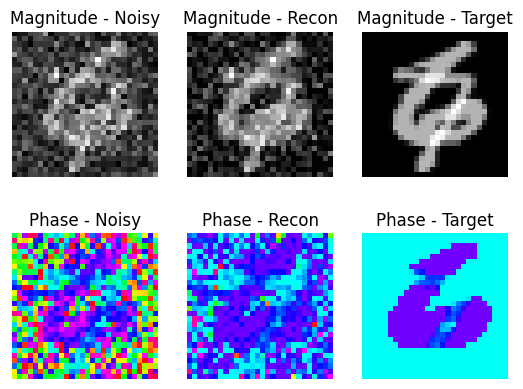

In [ ]:
# Predict with trained model (Torch version)
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Disable gradient computation
    inputs, outputs = next(iter(test_generator))  # Get a batch from the test generator
    inputs, outputs = inputs.to(device), outputs.to(device)  # Move data to the appropriate device
    predicted_output = model(inputs)  # Forward path

# Display the predicted output
import matplotlib.pyplot as plt
import numpy as np

icase = 0  # Display the first example
plt.figure()

# Magnitude - Noisy
plt.subplot(2, 3, 1)
plt.imshow(np.abs(inputs[icase, 0].cpu().numpy()), cmap='gray')
plt.title('Magnitude - Noisy')
plt.axis('off')

# Magnitude - Recon
plt.subplot(2, 3, 2)
plt.imshow(np.abs(predicted_output[icase, 0].cpu().numpy()), cmap='gray')
plt.title('Magnitude - Recon')
plt.axis('off')

# Magnitude - Target
plt.subplot(2, 3, 3)
plt.imshow(np.abs(outputs[icase, 0].cpu().numpy()), cmap='gray')
plt.title('Magnitude - Target')
plt.axis('off')

# Phase - Noisy
plt.subplot(2, 3, 4)
plt.imshow(np.angle(inputs[icase, 0].cpu().numpy()), vmin=-np.pi, vmax=np.pi, cmap='hsv')
plt.title('Phase - Noisy')
plt.axis('off')

# Phase - Recon
plt.subplot(2, 3, 5)
plt.imshow(np.angle(predicted_output[icase, 0].cpu().numpy()), vmin=-np.pi, vmax=np.pi, cmap='hsv')
plt.title('Phase - Recon')
plt.axis('off')

# Phase - Target
plt.subplot(2, 3, 6)
plt.imshow(np.angle(outputs[icase, 0].cpu().numpy()), vmin=-np.pi, vmax=np.pi, cmap='hsv')
plt.title('Phase - Target')
plt.axis('off')

plt.show()

## Physics-based unrolled network (complex-valued data with complex-valued operations)
Now we have all ingredients ready to put our learnable regularizer inside an unrolled reconstruction network. We will go over the steps of defining the architecture and setting up the data consistency layer. 
It is also conceivable to use the trainable network inside any other reconstruction scheme. For another example of a Plug and Play Prior, please refer to this [tutorial](https://github.com/ISMRM-MIT-CMR/CMR-DL-challenge/blob/master/challenge_plug_and_play_sample_solution.ipynb). 

We first define the data pipelines to feed the data into training, validation and test set. The MNIST database is used for showcasing. Since MNIST are real-valued images, a phase is simulated and added to the images to generate a complex-valued input. The fourier transformed image serves as k-space for data consistency. Single-MR-coil processing is performed. A retrospective undersampling according to a Parallel Imaging (PI) or Compressed Sensing (CS) like trajectory is simulated and applied to the data. The task of the network is to reconstruct the undersampled data with complex-valued operations.

### Database pipeline
First define the data pipelines (in the form of generator functions) for training, validation and test set. Retrospective undersampling is performed inside the generator functions. You can reuse your previous `ComplexDataGeneratorMNIST(TwoChannelDataGeneratorMNIST)` and the subsampling implementations from above. Before we can start with the dataloader we need to either extend the `ifft2c` and `fft2c` functions from above to account for the network channel dimension and operate on Tensors. Alternatively, you can also use the implementations provided by [MERLIN](https://github.com/midas-tum/merlin/blob/master/pytorch/merlinth/layers/fft.py). 

**Task 29: Implement an `fftnc` and `ifftnc` to operate on each axis of the Tensor.** <br/>

In [ ]:
from merlinth.layers.fft import fft2c, ifft2c

For the dataloader, we need to consider that in the case of a physics-based unrolled network, we want to provide the noisy/undersampled image, undersampled k-space, sampling mask, and sensitivy map (if multi-coil) as network input. You want to be able to provide an acceleration range ([minimum acceleration, maximum acceleration] between which a random acceleration is selected), acceleration type (`PI` or `CS`), the number of fully-sampled center lines, and the mode (`train`, `eval`, `test`). 

**Task 30: Implement the dataset class `ComplexRawDataGeneratorMNIST(ComplexDataGeneratorMNIST)`.** <br/>

To perform the retrospective undersampling, we need to integrate a `_subsample` function that operates on Tensors. You can adjust the above subsampling function modes 3 (CS) and 5 (PI).

**Task 31: Implement the CS and PI subsampling into the `_subsample` function in `ComplexRawDataGeneratorMNIST(ComplexDataGeneratorMNIST)`.** <br/>
**Task 32: Provide a `__getitem__` function to return `[noisy, kspace, mask], target`.** <br/>

In [ ]:
import torch
import numpy as np
from torch.utils.data import Dataset
from scipy.stats import norm as scs_norm

class ComplexRawDataGeneratorMNIST(ComplexDataGeneratorMNIST):
    """Generates complex-valued data with raw data (for data consistency) for PyTorch model"""

    def __init__(self, accelerations=[2, 4], accel_type='PI', center=20, mode='train'):
        """Initialization"""
        super().__init__(noise_level=0, mode=mode)
        self.dtype = torch.complex64
        self.accelerations = accelerations
        self.accel_type = accel_type
        self.center = int(center) if center > 1 else int(center * 28)  # center can be lines or percentage, assuming MNIST image size of 28x28
        self.kspace = self._generate_kspace()

    def _generate_kspace(self):
        """Generate k-space from images"""
        return merlinth.layers.fft2c(self.img).detach().clone().to(dtype=self.dtype, device=self.img.device)

    def _subsample(self, kspace):
        """Retrospective undersampling/sub-Nyquist sampling"""
        #kspace = torch.tensor(kspace, dtype=self.dtype, device=self.img.device)
        mask = torch.zeros(self.img.shape[1:], dtype=torch.float32, device=kspace.device)

        # Fully sampled center
        fscenter = (self.img.shape[2] // 2 - self.center // 2, self.img.shape[2] // 2 + self.center // 2)
        mask[:, fscenter[0]:fscenter[1]] = 1
        R = np.random.choice(self.accelerations)

        if self.accel_type == 'PI':
            # Parallel Imaging undersampling
            mask[:, ::R] = 1
        elif self.accel_type == 'CS':
            # Compressed Sensing like undersampling
            prob = torch.tensor([1/R, 1-1/R], device=kspace.device)
            mask[:, :] = torch.multinomial(prob, self.img.shape[2], replacement=True).float()
            mask[:, fscenter[0]:fscenter[1]] = 1

        kspace_us = (kspace * mask).detach().clone().to(dtype=self.dtype, device=kspace.device)
        return kspace_us, mask

    def __getitem__(self, index):
        """Generate one data sample"""
        sample = self.img[index]
        kspace = self.kspace[index]  # Get k-space for the sample

        # Get target
        target = sample.unsqueeze(0)  # Add channel dimension

        # Subsample k-space
        kspace_us, mask = self._subsample(kspace)  # kspace and mask do not need a channel dimension

        # Generate noisy input
        noisy = merlinth.layers.ifft2c(kspace_us).unsqueeze(0)  # Add channel dimension

        return [noisy, kspace_us, mask], target

**Task 33: Provide the respective data loader pipelines for training, validation and test.**

In [90]:
from torch.utils.data import DataLoader

# initialize some parameters
accelerations = [2, 4]  # simulate retrospectively accelerations in the range of e.g. 2x to 4x
accel_type = 'PI'  # simulated undersampling strategy: 'PI' = Parallel Imaging, 'CS' = Compressed Sensing
center = 20  # numbers of center lines or percent of fully sampled central region along ky phase-encoding, e.g. 0.1 := floor(10% * 28) ky center lines = 2 ky center lines 

# Data Generators (Data pipeline) for complex-valued data
# training set
#TODO: implement the data generator for training
training_generator = DataLoader(ComplexRawDataGeneratorMNIST(accelerations, accel_type, center, mode='train'), batch_size=32, shuffle=True)

# validation set
#TODO: implement the data generator for validation
validation_generator = DataLoader(ComplexRawDataGeneratorMNIST(accelerations, accel_type, center, mode='val'), batch_size=32, shuffle=False)

# test set
# ideally testing should be performed on real noisy cases and not simulated ones
#TODO: implement the data generator for testing
test_generator = DataLoader(ComplexRawDataGeneratorMNIST(accelerations, accel_type, center, mode='test'), batch_size=32, shuffle=False)

print('Training batches to process:', len(training_generator))
print('Validation batches to process:', len(validation_generator))
print('Test samples to process:', len(test_generator))

Training batches to process: 1500
Validation batches to process: 375
Test samples to process: 313


### Model
For the learnable regularizer we choose our previously defined complex-valued 3-layer residual network from Task 26.

Next we can work on the data consistency layer. You may either implement a conjugate gradient algorithm yourself or rely on the functions/data consistency layer provided within MERLIN: `merlinth.layers.DCPM`.
The conjugate gradient layer solves the data consistency term

$$ \min_x \frac{1}{2}\Vert Ax - y \Vert_2^2 $$

with a pre-conditioned prior $x_{denoise}$ on $x$, i.e. our denoised image output of the learnable regularizer. The problem can be equally stated as the regular conjugate gradient ($Ex=b$) with the preconditioning:

$$ A^H A x = A^H m + \lambda x_{denoise} $$

We suggest the following literature:
- Pruessmann, K. P.; Weiger, M.; Boernert, P. and Boesiger, P. [Advances in sensitivity encoding with arbitrary k-space trajectories](https://onlinelibrary.wiley.com/doi/full/10.1002/mrm.1241?sid=nlm%3Apubmed). Magn Reson Med 46: 638-651 (2001)

Let us first have a look at the forward and adjoint operators. You can either implement these single-coil (for the provided example data) operators yourself or use the ones provided by [MERLIN](https://github.com/midas-tum/merlin/blob/master/pytorch/merlinth/layers/mri.py).

**Task 34: Implement the forward and adjoint operators.**

In [95]:
from merlinth.layers.mri import ForwardOp, AdjointOp
A = ForwardOp(center=True)
AH = AdjointOp(center=True)

**Task 35: Implement the data consistency layer and build the unrolled network class as a `torch.nn.Module` class, which contains the learnable regularizer (previous Task 26) and the data consistency layer both unrolled by the amount of unrolls. Alternatively, you may toggle via a variable `is_residual` between the complex-valued 3-layer residual network (Task 26) and the complex-valued 3-layer CNN (Task 25). To stack multiple modules in a list, please use [`nn.ModuleList`](https://pytorch.org/docs/stable/generated/torch.nn.ModuleList.html). You may implement weight sharing of the learned regularizers or cascading individual regularizers. Please define the final unrolled model with 5 cascades.**

In [96]:
import torch
import torch.nn as nn
from merlinth.layers import DCPM
from merlinth.layers.mri import ForwardOp, AdjointOp

# Define unrolled reconstruction model
class UnrolledNetwork(nn.Module):
    def __init__(self, cascades, shared_params=True, is_residual=True):
        super(UnrolledNetwork, self).__init__()
        
        self.T = 1 if shared_params else cascades  # shared denoiser network or (new) cascaded denoisers
        self.T_end = cascades  # number of cascades
        
        # Prepare denoising networks
        if is_residual:
            self.denoiser = nn.ModuleList([Residual3LayerCNNc() for _ in range(self.T)])
        else:
            self.denoiser = nn.ModuleList([ThreeLayerCNNc() for _ in range(self.T)])
        
        A = ForwardOp(center=True)
        AH = AdjointOp(center=True)

        # Prepare data consistency blocks
        self.dc = nn.ModuleList([DCPM(A, AH, weight_init=1.0, max_iter=10) for _ in range(self.T)])
    
    def forward(self, inputs):
        x = inputs[0]  # undersampled image
        for i in range(self.T_end):  # unrolled network
            ii = i % self.T
            x = self.denoiser[ii](x)  # denoising regularizer
            x = self.dc[ii]([x] + list(inputs[1:]))  # data consistency
        return x

In [ ]:
# Instantiate the model
model = UnrolledNetwork(cascades=5)

# Example forward path
inputs, _ = next(iter(training_generator))  # Get a batch from the training generator
inputs = [inp.to(torch.device("cuda" if torch.cuda.is_available() else "cpu")) for inp in inputs]
model.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
output = model(inputs)

# Print model summary
print(model)

UnrolledNetwork(
  (denoiser): ModuleList(
    (0): Residual3LayerCNNc(
      (conv1): ComplexConv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu1): cReLU()
      (conv2): ComplexConv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu2): cReLU()
      (conv3): ComplexConv2d(8, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu3): cReLU()
    )
  )
  (dc): ModuleList(
    (0): DCPD(lambda_init=1, weight_scale=1.0, requires_grad=True)
  )
)


### Training

Before we can start our training we need to update our training loop to consider the additional network inputs and outputs.

**Task 36: Write an updated training loop. Use the previous training loop from Task 15 as starting point.**

In [ ]:
from tqdm import tqdm

# Define the training loop
def train_model_rawdata(model, train_loader, val_loader, criterion, optimizer, epochs, mse_metric=mse_metric, mae_metric=mae_metric):
    for epoch in range(epochs):
        model.train()  # Set the model to training mode
        train_loss = 0.0

        # Training loop
        print(f"Epoch {epoch + 1}/{epochs}")
        with tqdm(total=len(train_loader), desc="Training", unit="batch") as pbar:
            for inputs, targets in train_loader:
                inputs = [inp.to(torch.device("cuda" if torch.cuda.is_available() else "cpu")) for inp in inputs]
                targets = targets.to(device)  # Move data to device (e.g., GPU)
                optimizer.zero_grad()  # Clear gradients
                outputs = model(inputs)  # Forward path
                loss = criterion(outputs, targets)  # Compute loss
                loss.backward()  # Backward path
                optimizer.step()  # Update weights
                train_loss += loss.item()
                pbar.update(1)  # Update progress bar

        # Validation loop
        model.eval()  # Set the model to evaluation mode
        val_loss = 0.0
        val_mse = 0.0
        val_mae = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs = [inp.to(torch.device("cuda" if torch.cuda.is_available() else "cpu")) for inp in inputs]
                targets = targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()
                val_mse += mse_metric(outputs, targets)
                val_mae += mae_metric(outputs, targets)

        # Print epoch summary
        print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss / len(train_loader):.4f}, "
              f"Validation Loss: {val_loss / len(val_loader):.4f}, "
              f"Validation MSE: {val_mse / len(val_loader):.4f}, "
              f"Validation MAE: {val_mae / len(val_loader):.4f}")

**Task 37: Assign an Adam optimizer (learning rate 0.001) with complex-valued MSE loss function. Use the MSE and MAE for validation metrics. Train for 3 epochs.**

In [100]:
from merlinth.losses import mse, mae

criterion = mse
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer with learning rate 0.001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)  # Move model to device
train_model_rawdata(model, training_generator, validation_generator, criterion, optimizer, epochs=3, mse_metric=mse, mae_metric=mae)

Epoch 1/3


Training: 100%|██████████| 1500/1500 [07:38<00:00,  3.27batch/s]


Epoch 1/3, Train Loss: 0.5968, Validation Loss: 0.5763, Validation MSE: 0.5763, Validation MAE: 15.0406
Epoch 2/3


Training: 100%|██████████| 1500/1500 [07:34<00:00,  3.30batch/s]


Epoch 2/3, Train Loss: 0.5767, Validation Loss: 0.5779, Validation MSE: 0.5779, Validation MAE: 15.0599
Epoch 3/3


Training: 100%|██████████| 1500/1500 [08:32<00:00,  2.93batch/s]


Epoch 3/3, Train Loss: 0.5772, Validation Loss: 0.5775, Validation MSE: 0.5775, Validation MAE: 15.0537


### Test

**Task 38: Update the test loop from Task 16 to consider the input list.**

In [ ]:
# Evaluate the trained model
def evaluate_model_rawdata(model, test_loader, criterion, mse_metric=mse_metric, mae_metric=mae_metric):
    model.eval()  # Set the model to evaluation mode
    test_loss = 0.0
    test_mse = 0.0
    test_mae = 0.0

    with torch.no_grad():  # Disable gradient computation
        for inputs, targets in test_loader:
            inputs = [inp.to(torch.device("cuda" if torch.cuda.is_available() else "cpu")) for inp in inputs]
            targets = targets.to(device)
            outputs = model(inputs)  # Forward path
            loss = criterion(outputs, targets)  # Compute loss
            test_loss += loss.item()
            test_mse += mse_metric(outputs, targets)
            test_mae += mae_metric(outputs, targets)

    # Compute average metrics
    avg_loss = test_loss / len(test_loader)
    avg_mse = test_mse / len(test_loader)
    avg_mae = test_mae / len(test_loader)

    print(f"Test Loss: {avg_loss:.4f}, Test MSE: {avg_mse:.4f}, Test MAE: {avg_mae:.4f}")

**Task 39: Test the trained model to predict a denoised output and to display performance (metrics) on the test set.**

In [102]:
from merlinth.losses import mse, mae
# evaluate trained model
evaluate_model_rawdata(model, test_generator, criterion, mse_metric=mse, mae_metric=mae)

Test Loss: 0.5811, Test MSE: 0.5811, Test MAE: 15.1102


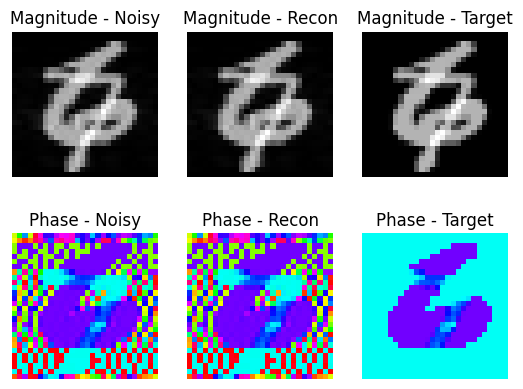

In [ ]:
# Predict with trained model (Torch version)
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Disable gradient computation
    inputs, outputs = next(iter(test_generator))  # Get a batch from the test generator
    inputs = [inp.to(device) for inp in inputs]  # Move inputs to the appropriate device
    outputs = outputs.to(device)  # Move outputs to the appropriate device
    predicted_output = model(inputs)  # Forward path

# Display the predicted output
import matplotlib.pyplot as plt
import numpy as np

icase = 0  # Display the first example
plt.figure()

# Magnitude - Noisy
plt.subplot(2, 3, 1)
plt.imshow(np.abs(inputs[0][icase, 0].cpu().numpy()), cmap='gray')
plt.title('Magnitude - Noisy')
plt.axis('off')

# Magnitude - Recon
plt.subplot(2, 3, 2)
plt.imshow(np.abs(predicted_output[icase, 0].cpu().numpy()), cmap='gray')
plt.title('Magnitude - Recon')
plt.axis('off')

# Magnitude - Target
plt.subplot(2, 3, 3)
plt.imshow(np.abs(outputs[icase, 0].cpu().numpy()), cmap='gray')
plt.title('Magnitude - Target')
plt.axis('off')

# Phase - Noisy
plt.subplot(2, 3, 4)
plt.imshow(np.angle(inputs[0][icase, 0].cpu().numpy()), vmin=-np.pi, vmax=np.pi, cmap='hsv')
plt.title('Phase - Noisy')
plt.axis('off')

# Phase - Recon
plt.subplot(2, 3, 5)
plt.imshow(np.angle(predicted_output[icase, 0].cpu().numpy()), vmin=-np.pi, vmax=np.pi, cmap='hsv')
plt.title('Phase - Recon')
plt.axis('off')

# Phase - Target
plt.subplot(2, 3, 6)
plt.imshow(np.angle(outputs[icase, 0].cpu().numpy()), vmin=-np.pi, vmax=np.pi, cmap='hsv')
plt.title('Phase - Target')
plt.axis('off')

plt.show()

# Further hands-on for Machine Learning reconstruction

You might want to check out further details for machine learning image reconstruction. We have compiled a few Jupyter notebooks to let you explore the image of complex-valued vs. real-valued processing and thec choice of the respective layers for that:
- [Image denoising (magnitude)](https://github.com/midas-tum/merlin/blob/master/notebooks/tutorial_denoising_real.ipynb)
- [Image denoising (2-channel real-valued)](https://github.com/midas-tum/merlin/blob/master/notebooks/tutorial_denoising_2chreal.ipynb)
- [Image denoising (complex-valued)](https://github.com/midas-tum/merlin/blob/master/notebooks/tutorial_denoising_complex.ipynb)
- [Image reconstruction (complex-valued)](https://github.com/midas-tum/merlin/blob/master/notebooks/tutorial_reconstruction_complex.ipynb)
- [Plug and Play Prior reconstruction](https://github.com/ISMRM-MIT-CMR/CMR-DL-challenge)
- [Complex-valued activation functions](https://github.com/midas-tum/merlin/blob/master/notebooks/tutorial_complex_activations.ipynb)
- [Complex layers](https://github.com/midas-tum/merlin/blob/master/notebooks/tutorial_complex_layers.ipynb)